# 0. Imports packages, modules and functions

## 0.1. Import modules

In [1]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import umap.umap_               as ump

from plotly      import express as px

from IPython.display            import Image
from IPython.display            import HTML
from scipy                      import stats
from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek
from sklearn                    import cluster
from sklearn                    import decomposition
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.manifold           import TSNE
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection    import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing      import OneHotEncoder
from pandas_profiling           import ProfileReport
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer

from xgboost import XGBClassifier

import datetime
import inflection
import math
import pickle
import random
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 0.2. Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

## 0.3. Loading data

In [3]:
 # load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding = "ISO-8859-1" )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## 0.4. Image controls

In [4]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Data description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39      17850.0  United Kingdom

## 1.2. Data dimensions

In [8]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


The dataset consist of more than 500,000 items purchases with different purchases must refer to the same purchase order and customer, while it has only 8 columns.

## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

The types of the invoice number, customer id and invoice date seem to have the wrong type. Customer ID and invoice number should be represented by the int number type, while the invoice date should be represented by a datetime.

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replacing NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalescing columns customer_id_x and customer_id_y
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Droping extra customer_id columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 0.27%


In [13]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

The data has many problems with NA purchase orders, that may be represented by some business problem or relevant information, such as reversed logistics to product change or devolution. It can be represented by both the negative quantities and the letters whitin the invoice number. All those data will be removed from the dataset.

## 1.6. Change dtypes

In [14]:
 # invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55  United Kingdom        17850
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39  United Kingdom        17850
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75  United Kingdom        17850
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39  United Kingdom        17850
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39  United Kingdom        17850

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

Even after the removal of NA values, it was not possible to remove all invoice numbers with a letter in it. So, it was not possible to change the invoice number type. Maybe it could be necessary to create features that properly represents the business problem behind the reason of a letter to appear in it. 

## 1.7. Descriptive statistics

It is intended to solve the clusterization problem with the RFM model, the descriptive statistics will be done again after the creation of the variables necessary to create the model.

In [16]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical attributes

In [17]:
# Central tendency - mean, median

mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(num_att.apply(np.std)).T
min_value = pd.DataFrame(num_att.apply(min)).T
max_value = pd.DataFrame(num_att.apply(max)).T
range_values = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
desc_stat

attributes       min      max      range          mean    median          std        skew       kurtosis
0     quantity -80995.00  80995.0  161990.00      9.603129      3.00   218.007397   -0.281253  120252.449063
1   unit_price -11062.06  38970.0   50032.06      4.623519      2.08    96.889538  186.257919   58848.017575
2  customer_id  12346.00  22709.0   10363.00  16678.153600  16241.00  2907.570262    0.493600      -0.792496

From the results we can observe values of standard deviation one order higher than the mean and the median, also with negative values. For the unit price, we can see that there are some occurrencies of products with price 0.

### 1.7.2. Categorical attributes

In [18]:
strings1 = len( cat_att.loc[ cat_att['invoice_no'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'invoice_no' ].drop_duplicates() )
strings2 = len( cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code' ].drop_duplicates() )
strings3 = len(cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ])

strings = cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()

total1 = len(cat_att['invoice_no'].drop_duplicates())
total2 = len(cat_att['stock_code'].drop_duplicates())

perc1 = 100 * strings1 / total1
perc2 = 100 * strings2 / total2

In [19]:
print('There are a total of {}/{} ({:,.2f} %)) different invoice numbers with a letter in it, {}/{} ({:,.2f} %) different stock codes with a letter in it and {} appearances of the letters {} as a stock code'.format( strings1, total1, perc1, strings2, total2, perc2, strings3, strings ))

There are a total of 3839/24446 (15.70 %)) different invoice numbers with a letter in it, 1073/3958 (27.11 %) different stock codes with a letter in it and 2754 appearances of the letters ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] as a stock code


# 2. Variable filtering

In [20]:
df2 = df1.copy()

All values of clients with a quantity equal or lesser than 0 will be removed from the dataset, since this type of customer will not be elected as a insider anyway. Afterwards, the quantity column will be removed, since its information is contained inside the ticket per product.

In [21]:
# prices higher than 1 cent
df2 = df2.loc[(df1['unit_price'] > 0.01), :]

# customer from a known region
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified' ] ) ]

# stock code different from not explained codes
df2 = df2[~df2['stock_code'].isin( ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS' 'B' 'CRUK'] ) ]

# returned products
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_returns['gross_returns'] = df2_returns['quantity'] * df2_returns['unit_price'] * (- 1)

# positive quantities
df2_purchase = df2.loc[(df2['quantity'] > 0), :]
df2_purchase.loc[:,'gross_purchases'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']


# 3. Feature engineering

In [22]:
df3 = df2.copy()

## 3.1. Feature creation

The features will be created in order to adjust the clusterization problem with a RFM model solution. For this, the main features within the model will be the monetary, frequency and recency. The monetary consists of the total amount of revenue from a given client, the frequency measures how many different purchases the client has made, while the recency measures the difference between the actual date (highest date within the dataset) and the last purchase date.

In [23]:
 # data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates().reset_index(drop=True)

### 3.1.1. Gross purchases and devolutions

In [24]:
# Purchases
df3['purchases'] = df2_purchase['quantity'] * df2_purchase['unit_price']
df3['devolutions'] = df2_returns['quantity'] * df2_returns['unit_price']

# Monetary
df_monetary = df3[['customer_id', 'purchases', 'devolutions']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.head(10)

customer_id  purchases  devolutions
0        17850    5391.21      -102.58
1        13047    3237.54      -158.44
2        12583    7281.38       -94.04
3        13748     948.25         0.00
4        15100     876.00      -240.90
5        15291    4668.30       -71.79
6        14688    5630.87      -523.49
7        17809    5411.91      -784.29
8        15311   60767.90     -1348.56
9        14527    8508.82      -797.44

### 3.1.2. Recency for purchases and devolutions - newest occurence

In [25]:
# Recency - Last day purchase
df_recency_p = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_p['recency_p'] = ( df3['invoice_date'].max() - df_recency_p['invoice_date'] ).dt.days
df_recency_p = df_recency_p[['customer_id', 'recency_p']].copy()
df_ref = pd.merge( df_ref, df_recency_p, on='customer_id', how='left' )

# Recency - Last day devolution
df_recency_d = df2_returns[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_d['recency_d'] = ( df3['invoice_date'].max() - df_recency_d['invoice_date'] ).dt.days
df_recency_d = df_recency_d[['customer_id', 'recency_d']].copy()
df_ref = pd.merge( df_ref, df_recency_d, on='customer_id', how='left' )
df_ref.head(10)

customer_id  purchases  devolutions  recency_p  recency_d
0        17850    5391.21      -102.58      372.0      302.0
1        13047    3237.54      -158.44       31.0       31.0
2        12583    7281.38       -94.04        2.0       56.0
3        13748     948.25         0.00       95.0        NaN
4        15100     876.00      -240.90      333.0      330.0
5        15291    4668.30       -71.79       25.0      172.0
6        14688    5630.87      -523.49        7.0        7.0
7        17809    5411.91      -784.29       16.0       16.0
8        15311   60767.90     -1348.56        0.0        0.0
9        14527    8508.82      -797.44        2.0        8.0

### 3.1.3. Quantity of product pruchased or returned

In [26]:
# Frequency - both purchases and returns
df_freq_p = df2_purchase[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_p'})
df_ref = pd.merge( df_ref, df_freq_p, on='customer_id', how='left' )

df_freq_d = df2_returns[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_d'})
df_ref = pd.merge( df_ref, df_freq_d, on='customer_id', how='left' )
df_ref.head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d
0        17850    5391.21      -102.58      372.0      302.0        35.0       -21.0
1        13047    3237.54      -158.44       31.0       31.0       132.0        -6.0
2        12583    7281.38       -94.04        2.0       56.0      1569.0       -50.0
3        13748     948.25         0.00       95.0        NaN       169.0         NaN
4        15100     876.00      -240.90      333.0      330.0        48.0       -22.0
5        15291    4668.30       -71.79       25.0      172.0       508.0       -27.0
6        14688    5630.87      -523.49        7.0        7.0       579.0      -281.0
7        17809    5411.91      -784.29       16.0       16.0       961.0       -41.0
8        15311   60767.90     -1348.56        0.0        0.0      2167.0      -231.0
9        14527    8508.82      -797.44        2.0        8.0       198.0        -3.0

### 3.1.4. Quantity of invoices for purchases and returns

In [27]:
# Frequency - both purchases and returns
df_invoices_p = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_p'})
df_ref = pd.merge( df_ref, df_invoices_p, on='customer_id', how='left' )

df_invoices_d = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_d'})
df_ref = pd.merge( df_ref, df_invoices_d, on='customer_id', how='left' )
df_ref.head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d
0        17850    5391.21      -102.58      372.0      302.0        35.0       -21.0        34.0         1.0
1        13047    3237.54      -158.44       31.0       31.0       132.0        -6.0        10.0         8.0
2        12583    7281.38       -94.04        2.0       56.0      1569.0       -50.0        15.0         3.0
3        13748     948.25         0.00       95.0        NaN       169.0         NaN         5.0         NaN
4        15100     876.00      -240.90      333.0      330.0        48.0       -22.0         3.0         3.0
5        15291    4668.30       -71.79       25.0      172.0       508.0       -27.0        15.0         5.0
6        14688    5630.87      -523.49        7.0        7.0       579.0      -281.0        21.0         6.0
7        17809    5411.91      -784.29       16.0       16.0       961.0       -41.0        12.0         3.0
8        15311   60767.90     -1348.56        0.0        0.0      2167.0      -231.0        91.0        27.0
9        14527    8508.82      -797.44        2.0        8.0       198.0        -3.0        55.0        31.0

### 3.1.5. Average ticket value

In [28]:
# average ticket - for purchases only
df_avg_ticket = df2_purchase.loc[:,['customer_id', 'gross_purchases']].groupby('customer_id').mean().reset_index().rename(columns={'gross_purchases':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket
0        17850    5391.21      -102.58      372.0      302.0        35.0       -21.0        34.0         1.0   18.152222
1        13047    3237.54      -158.44       31.0       31.0       132.0        -6.0        10.0         8.0   18.822907
2        12583    7281.38       -94.04        2.0       56.0      1569.0       -50.0        15.0         3.0   29.479271
3        13748     948.25         0.00       95.0        NaN       169.0         NaN         5.0         NaN   33.866071
4        15100     876.00      -240.90      333.0      330.0        48.0       -22.0         3.0         3.0  292.000000
5        15291    4668.30       -71.79       25.0      172.0       508.0       -27.0        15.0         5.0   45.323301
6        14688    5630.87      -523.49        7.0        7.0       579.0      -281.0        21.0         6.0   17.219786
7        17809    5411.91      -784.29       16.0       16.0       961.0       -41.0        12.0         3.0   88.719836
8        15311   60767.90     -1348.56        0.0        0.0      2167.0      -231.0        91.0        27.0   25.543464
9        14527    8508.82      -797.44        2.0        8.0       198.0        -3.0        55.0        31.0    8.753930

### 3.1.6. Average recency days

In [29]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=['True','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['next_next_customer_id'] = df_aux['next_customer_id'].shift(-1) # next customer
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift(-1) # next invoice date

#today =  datetime.datetime.fromtimestamp(df3['invoice_date'].max().to_datetime())
#today_date = datetime.datetime.strptime( today, '%Y-%m-%d')
today_date = df3['invoice_date'].max()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if (x['customer_id'] == x['next_customer_id']) 
                                                                                                    else ( (x['next_invoice_date'] - x['invoice_date']) if (x['customer_id'] == x['next_next_customer_id']) 
                                                                                                                                                        else (today_date - x['invoice_date']).days), axis=1)
df_avg_recency_days = df_aux[['customer_id','avg_recency_days']].groupby('customer_id').mean().reset_index()

# Merging
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

print(df_aux.head(10))
print(df_ref.head())

        customer_id invoice_date  next_customer_id  next_next_customer_id next_invoice_date  avg_recency_days
61619         12346   2017-01-16           12347.0                12347.0        2016-12-05               325
14938         12347   2016-12-05           12347.0                12347.0        2017-01-24                50
72246         12347   2017-01-24           12347.0                12347.0        2017-04-05                71
148285        12347   2017-04-05           12347.0                12347.0        2017-06-07                63
220572        12347   2017-06-07           12347.0                12347.0        2017-07-31                54
286621        12347   2017-07-31           12347.0                12347.0        2017-10-29                90
428957        12347   2017-10-29           12347.0                12348.0        2017-12-05                37
535004        12347   2017-12-05           12348.0                12348.0        2016-12-14                 2
34083     

### 3.1.7. Basket size and unique products

In [30]:
df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'sum'))
                                                                       .reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('stock_code', 'count'))
                                                                       .reset_index() )

df_aux['avg_variety'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

### 3.1.8. Frequency - purchases per day

In [31]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg( max_=('invoice_date', 'max'),
                                                                  min_=('invoice_date', 'min'),
                                                                  buys_=('invoice_no','count'))
                                                            .reset_index()  )
# Calculating the days
df_aux['days_'] = df_aux[['max_','min_']].apply(lambda x: (x['max_'] - x['min_']).days + 1 , axis=1)

# Frequency
df_aux['purchases_pday'] = df_aux[['buys_','days_']].apply(lambda x: x['buys_'] / x['days_'] if (x['days_'] !=0 ) else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id','purchases_pday']], on='customer_id', how='left')
df_ref.sample(20)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  n_purchase_x  n_products_x  avg_basket_size  n_purchase_y  n_products_y  avg_variety  purchases_pday
3426        17469    1870.97       -27.91       16.0      156.0        94.0        -9.0         5.0         1.0   21.261023         34.000000           5.0         787.0           157.40           5.0          88.0        17.60        0.026455
4071        12556     603.71         0.00       50.0        NaN        74.0         NaN         2.0         NaN    4.989339         75.500000           2.0         358.0           179.00           2.0         121.0        60.50        0.019608
5821        14946     100.90         0.00       14.0        NaN        14.0         NaN         1.0         NaN   33.633333         14.000000           1.0          22.0            22.00           1.0           3.0         3.00        1.000000
2176        19753     580.41         0.00      283.0        NaN        16.0         NaN         1.0         NaN   11.845102        283.000000           1.0          77.0            77.00           1.0          49.0        49.00        1.000000
772         15689     254.10         0.00      119.0        NaN        28.0         NaN         2.0         NaN   28.233333        180.500000           2.0          84.0            42.00           2.0           9.0         4.50        0.008230
414         16654     601.27        -6.30      141.0      220.0       135.0        -1.0         4.0         1.0   20.733448         73.600000           4.0         282.0            70.50           4.0          29.0         7.25        0.017544
3331        14421     813.11         0.00       57.0        NaN       112.0         NaN         2.0         NaN   30.115185        105.500000           2.0         365.0           182.50           2.0          27.0        13.50        0.012903
1301        16655    3794.52         0.00       17.0        NaN       448.0         NaN         6.0         NaN   14.538391         55.166667           6.0        2367.0           394.50           6.0         261.0        43.50        0.019048
3745        17101    1621.73         0.00       10.0        NaN       407.0         NaN         4.0         NaN   38.612619         44.500000           4.0         815.0           203.75           4.0          42.0        10.50        0.023669
631         19145      21.30         0.00      365.0        NaN        16.0         NaN         1.0         NaN    7.100000        365.000000           1.0          16.0            16.00           1.0           3.0         3.00        1.000000
836         18044    2088.60        -2.95        4.0       35.0       120.0        -1.0        10.0         1.0   16.445669         32.727273          10.0        1033.0           103.30          10.0         127.0        12.70        0.028011
3454        13391      59.80         0.00      203.0        NaN         4.0         NaN         1.0         NaN   59.800000        203.000000           1.0           4.0             4.00           1.0           1.0         1.00        1.000000
2774        14023     584.07         0.00        7.0        NaN       124.0         NaN         2.0         NaN   18.840968        125.000000           2.0         345.0           172.50           2.0          31.0        15.50        0.008197
1680        14549     289.24         0.00      311.0        NaN        63.0         NaN         1.0         NaN    5.165000        311.000000           1.0         136.0           136.00           1.0          56.0        56.00        1.000000
5142        13464     674.68         0.00       58.0        NaN        87.0         NaN         1.0         NaN   16.455610         58.000000           1.0         403.0           403.00           1.0          41.0        41.00        1.000000
4137        21233     332.04         0.00      144.0        NaN        11.0         NaN         1.0   

In [32]:
df_ref.isna().sum()

customer_id            0
purchases              0
devolutions            0
recency_p            215
recency_d           4201
quantity_p           215
quantity_d          4201
invoices_p           215
invoices_d          4201
avg_ticket           215
avg_recency_days       0
n_purchase_x         215
n_products_x         215
avg_basket_size      215
n_purchase_y         215
n_products_y         215
avg_variety          215
purchases_pday       215
dtype: int64

In [33]:
print( 'Number of rows: {}'.format( df_ref.shape[0] ) )
print( 'Number of cols: {}'.format( df_ref.shape[1] ) )

Number of rows: 5971
Number of cols: 18


## 3.2. Feature engineering

In [34]:
df_ref = df_ref.drop(['n_purchase_x', 'n_purchase_y', 'n_products_x', 'n_products_y'], axis=1)

df_ref['devolutions'] = df_ref['devolutions'].apply(lambda x: (-1*x) if x < 0   else x )

df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_d'] = df_ref['recency_d'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x*(-1) )
df_ref['invoices_d'] = df_ref['invoices_d'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_p'] = df_ref['recency_p'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['invoices_p'] = df_ref['invoices_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_ticket'] = df_ref['avg_ticket'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['purchases_pday'] = df_ref['purchases_pday'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['avg_variety'] = df_ref['avg_variety'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_basket_size'] = df_ref['avg_basket_size'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref.sample(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday
4285        15149     520.80          0.0      133.0      365.0        74.0        -0.0         1.0         0.0   22.643478        133.000000       128.000000    23.000000        1.000000
2870        14958     499.68          0.0      147.0      365.0        55.0        -0.0         3.0         0.0   11.897143         81.666667        43.000000    14.000000        0.030303
3179        17384     336.40          0.0       19.0      365.0        52.0        -0.0         2.0         0.0   22.426667        109.500000        44.000000     7.500000        0.009950
5770        16956     308.74         16.4       17.0        9.0        35.0         1.0         1.0         1.0   19.296250          8.500000       114.000000    16.000000        1.000000
996         15204     316.58          0.0      357.0      365.0       234.0        -0.0         1.0         0.0   35.175556        357.000000       258.000000     9.000000        1.000000
4974        21885    4701.22          0.0       66.0      365.0       728.0        -0.0         1.0         0.0   53.422955         66.000000      1064.000000    88.000000        1.000000
106         14741    1400.34          0.0       11.0      365.0       275.0        -0.0         6.0         0.0   23.734576         62.000000       140.166667     9.833333        0.016575
5864        22581      16.40          0.0       10.0      365.0         1.0        -0.0         1.0         0.0    8.200000         10.000000         2.000000     2.000000        1.000000
2133        16668     306.72          0.0       15.0      365.0        90.0        -0.0         6.0         0.0   15.336000         47.333333        53.000000     3.333333        0.022222
5395        22182       2.08          0.0       42.0      365.0         1.0        -0.0         1.0         0.0    2.080000         42.000000         1.000000     1.000000        1.000000

In [35]:
df_ref['gross_revenue'] = (df_ref['purchases'] - df_ref['devolutions'])
df_ref['relative_revenue'] = (df_ref['purchases'] - df_ref['devolutions']) / (df_ref['purchases'] + df_ref['devolutions'])
df_ref['relative_quantity'] = (df_ref['quantity_p'] - df_ref['quantity_d']) / (df_ref['quantity_p'] + df_ref['quantity_d'])

#df_ref['relative_invoices'] = (df_ref['invoices_p'] - df_ref['invoices_d'])
#df_ref = df_ref.drop(columns=['purchases','devolutions','invoices_p','invoices_d','recency_d'], axis=1)

In [36]:
df_ref.isna().sum()
total_variety = len(df2['description'].drop_duplicates())
total_variety

print( math.log( (df_ref['avg_variety'].mean()), 10))

1.5821541509539592


There were a problem whith clients that did not have made any purchase in the analyzed period or did not have done any devolution. For those clients, recency was considered as 365 days or 1 year and the frequency of purchase or devolution was considered 0.

## 3.3. RFM model descriptive statistics

In [37]:
# Central tendency - mean, median

mean = pd.DataFrame(df_ref.apply(np.mean)).T
median = pd.DataFrame(df_ref.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(df_ref.apply(np.std)).T
min_value = pd.DataFrame(df_ref.apply(min)).T
max_value = pd.DataFrame(df_ref.apply(max)).T
range_values = pd.DataFrame(df_ref.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(df_ref.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(df_ref.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
desc_stat

attributes       min        max      range          mean        median          std       skew     kurtosis
0         customer_id  12346.00   22709.00   10363.00  16765.631887  16392.000000  2882.295644   0.370682    -0.958112
1           purchases      0.00  280206.02  280206.02   1785.401859    599.970000  7788.693573  21.773640   620.201010
2         devolutions      0.00  168469.60  168469.60    150.192060      0.000000  2602.613094  50.916424  3072.075434
3           recency_p      0.00     373.00     373.00    126.001507     77.000000   118.720949   0.748847    -0.810383
4           recency_d      0.00     373.00     373.00    297.960643    365.000000   120.089618  -1.463354     0.461361
5          quantity_p      0.00   80996.00   80996.00    254.910735     91.000000  1701.348536  35.097843  1502.456269
6          quantity_d     -0.00   80995.00   80995.00     40.920951      0.000000  1435.725633  53.230140  2885.966697
7          invoices_p      0.00     209.00     209.00      3.339977      1.000000     6.736392  13.458198   316.395646
8          invoices_d      0.00      47.00      47.00      0.642104      0.000000     1.861841  10.062085   174.893821
9          avg_ticket      0.00   77183.60   77183.60     60.594494     15.724600  1274.186238  51.961085  2881.449309
10   avg_recency_days      0.00     373.00     373.00    120.876580     80.000000   102.902782   0.968838    -0.216140
11    avg_basket_size      0.00   74215.00   74215.00    254.165206    142.666667  1169.972880  49.857338  2915.667275
12        avg_variety      0.00    1114.00    1114.00     38.207986     17.000000    75.824553   5.086637    33.552994
13     purchases_pday      0.00      17.00      17.00      0.531211      0.666667     0.550668   4.713846   132.912632
14      gross_revenue -17836.46  279489.02  297325.48   1635.209799    589.150000  7205.053429  23.795967   757.345168
15   relative_revenue     -1.00       1.00       2.00      0.899889      1.000000     0.382521  -4.525203    19.287724
16  relative_quantity     -1.00       1.00       2.00      0.885941      1.000000     0.389268  -4.259875    17.347649

A first glimpse at the statistical analysis shows that all variables from the RFM model (gross revenue, recency days and number of invoices) shows a high skewed data with maximum values very distant from both the mean and median values. The skewness and the kurtosis can be seen at the distribution graphics of each variable. Also, there are customers with zero or less quantity of products and an non-null value of revenue, this makes the ticket per product go to extremely high values, increasing the outliers for this feature.

In [38]:
for i in range(len(df_ref)):
    df_ref.loc[i,'monetary_score'] = math.log(max(0.001, df_ref.loc[i,'gross_revenue']), 10)
    df_ref.loc[i,'ticket_score'] = math.log(max(0.001, 2 * df_ref.loc[i,'avg_ticket'] ),10)
    df_ref.loc[i,'recency_score'] = 10 / ((1 + df_ref.loc[i,'avg_recency_days']) ** 0.5 )
    df_ref.loc[i,'behavior_score'] = ( 2 * max(0.0, df_ref.loc[i,'relative_quantity']) * max(0.0, df_ref.loc[i,'relative_revenue']) * math.log(max(0.001, df_ref.loc[i,'avg_variety']), 10) )

In [39]:
df_ref.sample(20)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
5126        21993       0.00        73.24      365.0       59.0         0.0         1.0         0.0         1.0    0.000000         59.000000         0.000000     0.000000        0.000000         -73.24         -1.000000          -1.000000       -3.000000     -3.000000       1.290994       -0.000000
5514        13532     210.31         0.00       33.0      365.0        55.0        -0.0         1.0         0.0    3.186515         33.000000       129.000000    66.000000        1.000000         210.31          1.000000           1.000000        2.322860      0.804346       1.714986        3.639088
118         13108     350.06         0.00      372.0      365.0       202.0        -0.0         1.0         0.0   35.006000        372.000000       298.000000    10.000000        1.000000         350.06          1.000000           1.000000        2.544142      1.845172       0.517780        2.000000
4398        13307      15.00         0.00      120.0      365.0         4.0        -0.0         1.0         0.0   15.000000        120.000000         4.000000     1.000000        1.000000          15.00          1.000000           1.000000        1.176091      1.477121       0.909091        0.000000
4686        21700    1335.26         0.00       87.0      365.0        75.0        -0.0         1.0         0.0    8.092485         87.000000       336.000000   165.000000        1.000000        1335.26          1.000000           1.000000        3.125566      1.209112       1.066004        4.434968
4019        12977      39.24         0.00      156.0      365.0         6.0        -0.0         1.0         0.0    4.360000        156.000000        12.000000     9.000000        1.000000          39.24          1.000000           1.000000        1.593729      0.940516       0.798087        1.908485
1009        12705    6868.29        54.05       15.0       66.0       357.0         9.0         9.0         5.0   20.563743         27.461538       444.111111    37.111111        0.026239        6814.24          0.984384           0.950820        3.833417      1.614132       1.874437        2.938022
2560        16809     914.69         1.95       23.0      262.0        51.0         1.0         5.0         1.0    6.138859         52.400000       130.400000    29.800000        0.020833         912.74          0.995745           0.961538        2.960347      1.089118       1.368451        2.822969
1566        17075     834.12        20.35       17.0      253.0        78.0         1.0         4.0         1.0   10.832727         79.250000        73.000000    19.250000        0.013289         813.77          0.952368           0.974684        2.910502      1.335768       1.116291        2.384565
2919        14111     692.85         4.25       14.0       85.0       398.0         1.0         4.0         1.0   69.285000         48.200000       114.500000     2.500000        0.017544         688.60          0.987807           0.994987        2.837967      2.141669       1.425665        0.782235
1751        17929     843.00         8.50       11.0       77.0        90.0         1.0         4.0         1.0  168.600000         61.600000        27.000000     1.250000        0.013423         834.50          0.980035           0.978022        2.921426      2.527888       1.263900        0.185776
3744        13384    4151.93        29.65       30.0      121.0       697.0         6.0         7.0         2.0   27.315329         22.250000       346.000000    21.714286        0.046980        4122.28          0.985819           0.982930        3.615137      1.737436       2.073903        2.590589
5230        22064    1911.88         0.00       52.0      365.0       125.0        -0.0      

# 4. Exploratory data analysis

In [40]:
df4 = df_ref.copy()

In [41]:
# filter to analyze only valid customers
# returned products
df4 = df4.loc[df4['customer_id'] <19000, :]

## 4.1. Univariate analysis

- Relevant metrics
    - Dispersion metrics: we need features that have a high variability, so the odds to create separate and contrated clusters increases;
    - Descriptive statistics: features with higher range or difference between Q1 and Q3, when combined with other feature with similar characteristics increases the probability of separated clusters;
    - Min, Max, Range
    - Standard deviation and variance
    - Variance coefficient

In [42]:
profile = ProfileReport(df4)
profile.to_file('../reports/univariate_output.html')

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
df4.dtypes

customer_id            int64
purchases            float64
devolutions          float64
recency_p            float64
recency_d            float64
quantity_p           float64
quantity_d           float64
invoices_p           float64
invoices_d           float64
avg_ticket           float64
avg_recency_days     float64
avg_basket_size      float64
avg_variety          float64
purchases_pday       float64
gross_revenue        float64
relative_revenue     float64
relative_quantity    float64
monetary_score       float64
ticket_score         float64
recency_score        float64
behavior_score       float64
dtype: object

### 4.1.1. Looking for outliers

- Features for attention
    - quantity_p for values above 20k
    - quantity_d for values above 4k
    - avg_ticket for values above 4k
    - avg_basket_size for values above 4k
    - purchases_pday for value 17
    - gross_revenue for above 70k
- Features with high correlation
    - recency_p w/ avg_recency_days
    - quantity_p w/ quantity_d
    - quantity_p w/ avg_basket_size
    - quantity_p w/ gross_revenue
    - quantity_d w/ relative variables (all)
    - relative variables are highly correlated between themselves

In [44]:
# looking for outliers to quantity of items purchased
df4[df4['quantity_p'] > 20000].head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d    avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
434         17450  194550.79      7068.62        8.0       10.0     38639.0       955.0        46.0         9.0    577.302047         11.121212      1521.586957     7.326087        0.127778      187482.17          0.929882           0.951760        5.272960      3.062433       2.872281    1.530866e+00
1400        12346   77183.60     77183.60      325.0      325.0     74215.0     74215.0         1.0         1.0  77183.600000        325.000000     74215.000000     1.000000        1.000000           0.00          0.000000           0.000000       -3.000000      5.188555       0.553849    0.000000e+00
1728        16333   26626.80         0.00        7.0      365.0     21352.0        -0.0        22.0         0.0    591.706667         23.769231      1462.909091     2.045455        0.072607       26626.80          1.000000           1.000000        4.425319      3.073136       2.009295    6.215797e-01
3411        16446  168472.50    168469.60        0.0        0.0     80996.0     80995.0         2.0         1.0  56157.500000        102.500000     40498.500000     1.500000        0.009709           2.90          0.000009           0.000006        0.462398      5.050438       0.982946    1.871197e-11

In [45]:
# looking for outliers to quantity of items returned
df4[df4['quantity_d'] > 4000].head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d    avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
13          16029   81024.84     30032.23       38.0       52.0     10828.0      4873.0        63.0        13.0    334.813388          8.288889       638.222222     3.841270        0.187500       50992.61          0.459157           0.379275        4.707507      2.825833       3.281090    2.035688e-01
161         15838   33643.08       292.32       11.0      106.0      6474.0      9361.0        19.0         2.0    201.455569         21.882353       966.736842     8.789474        0.053221       33350.76          0.982772          -0.182318        4.523106      2.605209       2.090498    0.000000e+00
984         12931   42055.96      8593.15       21.0       28.0     16288.0      4027.0        15.0         5.0    512.877561         23.800000      1866.933333     5.466667        0.044510       33462.81          0.660679           0.603544        4.524562      3.011044       2.008048    5.883324e-01
1281        15749   44534.30     22998.40      235.0      235.0      9014.0      9014.0         3.0         1.0   4453.430000        166.000000      6009.333333     3.333333        0.030612       21535.90          0.318896           0.000000        4.333163      3.949725       0.773823    0.000000e+00
1400        12346   77183.60     77183.60      325.0      325.0     74215.0     74215.0         1.0         1.0  77183.600000        325.000000     74215.000000     1.000000        1.000000           0.00          0.000000           0.000000       -3.000000      5.188555       0.553849    0.000000e+00
3411        16446  168472.50    168469.60        0.0        0.0     80996.0     80995.0         2.0         1.0  56157.500000        102.500000     40498.500000     1.500000        0.009709           2.90          0.000009           0.000006        0.462398      5.050438       0.982946    1.871197e-11

It seems that customers 12346 and 16446 had some problem with the data quality in database, since they have bought a high number of items and returned them. They will be removed from the dataset in order to increase the model result. Other customers with a high number of returns also had a high number of purchases, which seems reasonable.

In [46]:
# looking for outliers to the average ticket of purchases
df4[df4['avg_ticket'] > 3000].head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
1281        15749    44534.3      22998.4      235.0      235.0      9014.0      9014.0         3.0         1.0     4453.43             166.0      6009.333333     3.333333        0.030612        21535.9          0.318896           0.000000        4.333163      3.949725       0.773823    0.000000e+00
1400        12346    77183.6      77183.6      325.0      325.0     74215.0     74215.0         1.0         1.0    77183.60             325.0     74215.000000     1.000000        1.000000            0.0          0.000000           0.000000       -3.000000      5.188555       0.553849    0.000000e+00
3411        16446   168472.5     168469.6        0.0        0.0     80996.0     80995.0         2.0         1.0    56157.50             102.5     40498.500000     1.500000        0.009709            2.9          0.000009           0.000006        0.462398      5.050438       0.982946    1.871197e-11
3536        13135     3096.0          0.0      196.0      365.0      4300.0        -0.0         1.0         0.0     3096.00             196.0      4300.000000     1.000000        1.000000         3096.0          1.000000           1.000000        3.490801      3.791831       0.712470    0.000000e+00
3707        15098    39916.5      39267.0      182.0      182.0        61.0        61.0         3.0         2.0    13305.50             182.0        40.333333     1.000000        3.000000          649.5          0.008202           0.000000        2.812579      4.425061       0.739221    0.000000e+00
5951        15195     3861.0          0.0        2.0      365.0      1404.0        -0.0         1.0         0.0     3861.00               2.0      1404.000000     1.000000        1.000000         3861.0          1.000000           1.000000        3.586700      3.887730       5.773503    0.000000e+00

Again, clients 12346 and 16446 shows as an outliers to the average ticket, due to the high amount of items purchases, however with no gross revenue. At this point, it seems that customers 15098 also had some problem, since it has a liquid purchased quantity of 0, however with some gross revenue (purchases higher than returns), this customer will also be removed from the dataset. Also customer 15749 have the same behavior as 15098 and will be removed.

In [47]:
# looking for outliers to the average basket size
df4[df4['avg_basket_size'] > 3000].head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d    avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
203         16754    2002.40         0.00      372.0      365.0      4280.0        -0.0         1.0         0.0   1001.200000        372.000000      4280.000000     2.000000        1.000000        2002.40          1.000000           1.000000        3.301551      3.301551       0.517780    6.020600e-01
1168        12415  124914.53      1189.08       24.0       35.0      9932.0       369.0        21.0         5.0    174.950322         18.722222      3684.476190    34.000000        0.066879      123725.45          0.981141           0.928356        5.092459      2.543945       2.251760    2.789891e+00
1281        15749   44534.30     22998.40      235.0      235.0      9014.0      9014.0         3.0         1.0   4453.430000        166.000000      6009.333333     3.333333        0.030612       21535.90          0.318896           0.000000        4.333163      3.949725       0.773823    0.000000e+00
1400        12346   77183.60     77183.60      325.0      325.0     74215.0     74215.0         1.0         1.0  77183.600000        325.000000     74215.000000     1.000000        1.000000           0.00          0.000000           0.000000       -3.000000      5.188555       0.553849    0.000000e+00
3411        16446  168472.50    168469.60        0.0        0.0     80996.0     80995.0         2.0         1.0  56157.500000        102.500000     40498.500000     1.500000        0.009709           2.90          0.000009           0.000006        0.462398      5.050438       0.982946    1.871197e-11
3536        13135    3096.00         0.00      196.0      365.0      4300.0        -0.0         1.0         0.0   3096.000000        196.000000      4300.000000     1.000000        1.000000        3096.00          1.000000           1.000000        3.490801      3.791831       0.712470    0.000000e+00
4440        12688    4873.81         0.00      113.0      365.0       610.0        -0.0         1.0         0.0     28.501813        113.000000      3028.000000   171.000000        1.000000        4873.81          1.000000           1.000000        3.687869      1.755902       0.936586    4.465992e+00
4684        18251    4314.72         0.00       87.0      365.0      3528.0        -0.0         1.0         0.0    269.670000         87.000000      7824.000000    16.000000        1.000000        4314.72          1.000000           1.000000        3.634953      2.731863       1.066004    2.408240e+00

In [48]:
# looking for outliers to the average basket size
df4[df4['purchases_pday'] == 17].head(10)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
0        17850    5391.21       102.58      372.0      302.0        35.0        21.0        34.0         1.0   18.152222        124.333333        50.970588     8.735294            17.0        5288.63          0.962656               0.25        3.723343       1.55996       0.893237        0.453063

In [49]:
# looking for outliers to the average ticket of purchases
df4[df4['gross_revenue'] > 50000].head(20)

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score
8           15311   60767.90      1348.56        0.0        0.0      2167.0       231.0        91.0        27.0   25.543464          4.098901       419.714286    26.142857        0.243316       59419.34          0.956580           0.807339        4.773928      1.708310       4.428552        2.189199
13          16029   81024.84     30032.23       38.0       52.0     10828.0      4873.0        63.0        13.0  334.813388          8.288889       638.222222     3.841270        0.187500       50992.61          0.459157           0.379275        4.707507      2.825833       3.281090        0.203569
16          17511   91062.38      2937.00        2.0       16.0      4375.0       125.0        31.0        15.0   94.561142         11.303030      2082.225806    31.064516        0.083333       88125.38          0.937510           0.944444        4.945101      2.276743       2.850979        2.642581
37          13694   65039.62      2386.52        3.0       25.0     13369.0       500.0        50.0        10.0  114.506373          9.097561      1266.240000    11.360000        0.134771       62653.10          0.929211           0.927897        4.796943      2.359860       3.146964        1.819919
67          14911  143825.06     11252.44        1.0        8.0      4247.0      1608.0       201.0        47.0   25.343623          2.554795       399.328358    28.233831        0.538874      132572.62          0.854880           0.450726        5.122454      1.704899       5.303869        1.118011
173         15061   54534.14       305.40        3.0       70.0      6506.0       186.0        48.0         7.0  135.320447         11.272727       602.500000     8.395833        0.129730       54228.74          0.988862           0.944411        4.734230      2.432393       2.854496        1.725952
192         14156  117379.63      3995.49        9.0       16.0      9208.0       658.0        55.0        11.0   83.842593          7.294118      1052.454545    25.454545        0.151515      113384.14          0.934163           0.866613        5.054552      2.224495       3.472281        2.276095
251         17949   58510.48      5759.64        1.0        7.0     17376.0      2399.0        45.0         7.0  835.864000         11.967742       678.800000     1.555556        0.121294       52750.84          0.820768           0.757370        4.722229      3.223166       2.776948        0.238562
267         15769   56252.72      4429.00        7.0       64.0      7846.0      1202.0        26.0         3.0  432.713231         15.458333      1141.230769     5.000000        0.071233       51823.72          0.854025           0.734306        4.714529      2.937230       2.464944        0.876670
280         13089   58825.83      1439.95        2.0       53.0      1815.0       144.0        97.0        21.0   32.357442          4.445783       320.309278    18.742268        0.263587       57385.88          0.952213           0.852986        4.758805      1.811004       4.285187        2.067636
434         17450  194550.79      7068.62        8.0       10.0     38639.0       955.0        46.0         9.0  577.302047         11.121212      1521.586957     7.326087        0.127778      187482.17          0.929882           0.951760        5.272960      3.062433       2.872281        1.530866
504         18102  259657.30      3218.81        0.0      142.0     12872.0         1.0        60.0         2.0  602.453132         13.592593      1068.733333     7.183333        0.163043      256438.49          0.975511           0.999845        5.408983      3.080953       2.617784        1.670451
840         14298   51527.30       664.86        8.0        3.0      5581.0       286.0      

All clients with gross revenue higher than 50000 seems to behave similarly, with small values for recency of purchases and high values for relative revenue and relative invoices (where 1 means that the customer has only purchases and -1 meaning that the customer only returns). At this point, only 4 customers will be considered as outliers and removed from the dataset: 12346,15098,15749,16446.

In [50]:
customers_outliers = [12346,15098,15749,16446]
df4 = df4[~df4['customer_id'].isin(customers_outliers)]

### 4.2. Bivariate analysis

In [51]:
cols = ['customer_id']
df_bivariate = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

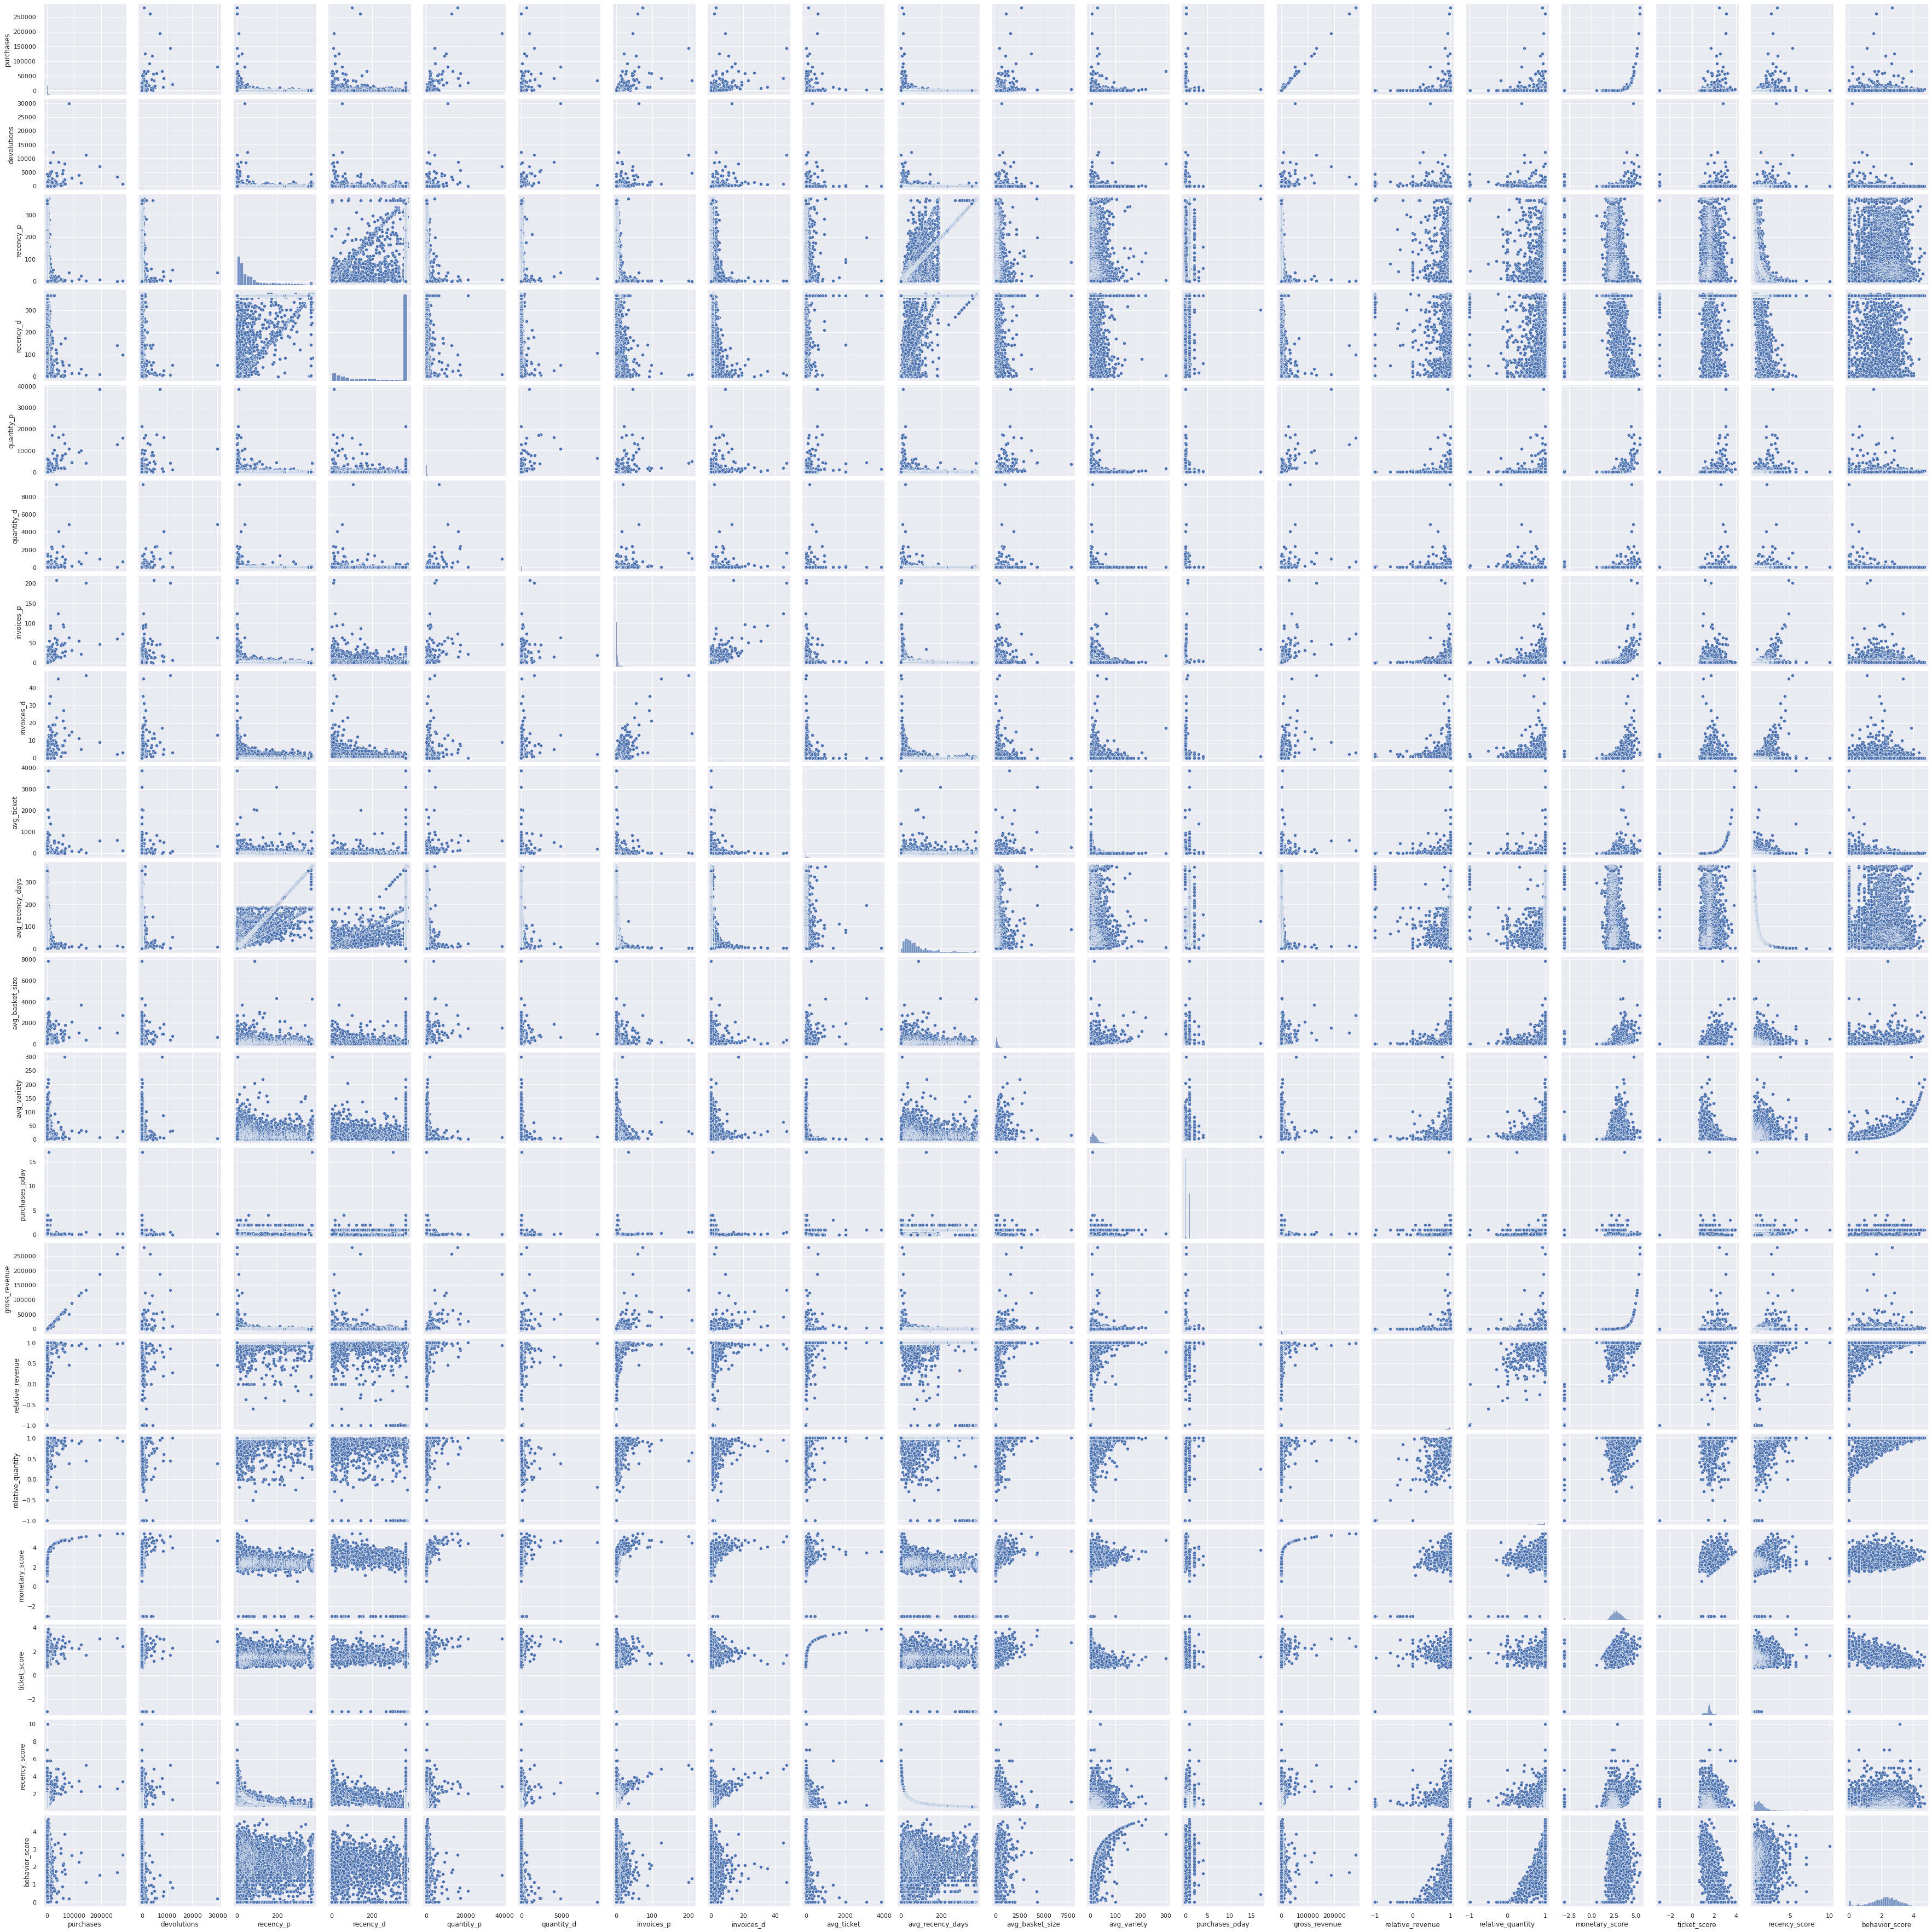

In [52]:
plt.figure(figsize=(25,12))
sns.pairplot(df_bivariate)


In [53]:
df4.head()
df4.columns

Index(['customer_id', 'purchases', 'devolutions', 'recency_p', 'recency_d',
       'quantity_p', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_ticket',
       'avg_recency_days', 'avg_basket_size', 'avg_variety', 'purchases_pday',
       'gross_revenue', 'relative_revenue', 'relative_quantity',
       'monetary_score', 'ticket_score', 'recency_score', 'behavior_score'],
      dtype='object')

## 4.3. Data space analysis

In [54]:
data_space = df4.copy()
data_space = data_space.drop(columns=['customer_id', 'purchases', 'devolutions', 'recency_p', 'recency_d', 'quantity_p', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_ticket','avg_recency_days', 'avg_basket_size', 'avg_variety', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)

rs = RobustScaler()
#rs = StandardScaler()

#data_space['purchases'] = rs.fit_transform( data_space[['purchases']].values )
#data_space['devolutions'] = rs.fit_transform( data_space[['devolutions']].values )
#data_space['purc_dev'] = rs.fit_transform( data_space[['purc_dev']].values )
#data_space['recency_p'] = rs.fit_transform( data_space[['recency_p']].values )
#data_space['recency_d'] = rs.fit_transform( data_space[['recency_d']].values )
#data_space['quantity_p'] = rs.fit_transform( data_space[['quantity_p']].values )
#data_space['quantity_d'] = rs.fit_transform( data_space[['quantity_d']].values )
#data_space['invoices_p'] = rs.fit_transform( data_space[['invoices_p']].values )
#data_space['invoices_d'] = rs.fit_transform( data_space[['invoices_d']].values )

data_space['gross_revenue'] = rs.fit_transform( data_space[['gross_revenue']].values )
#data_space['avg_ticket'] = rs.fit_transform( data_space[['avg_ticket']].values )
#data_space['avg_recency_days'] = rs.fit_transform( data_space[['avg_recency_days']].values )
#data_space['avg_basket_size'] = rs.fit_transform( data_space[['avg_basket_size']].values )
#data_space['avg_variety'] = rs.fit_transform( data_space[['avg_variety']].values )
#data_space['relative_quantity'] = rs.fit_transform( data_space[['relative_quantity']].values )
#data_space['relative_invoices'] = rs.fit_transform( data_space[['relative_invoices']].values )
#data_space['purchases_pday'] = rs.fit_transform( data_space[['purchases_pday']].values )

### 4.3.1. PCA - 

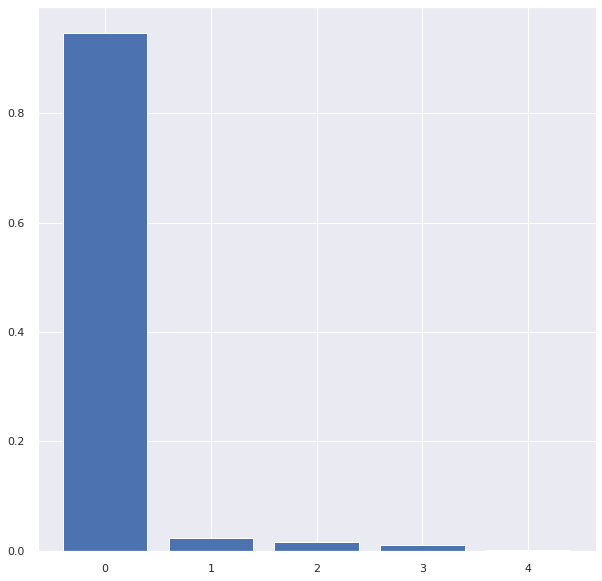

In [55]:
X_PCA = data_space.copy()
pca = decomposition.PCA(n_components=X_PCA.shape[1])

principal_component = pca.fit_transform(X_PCA)

features = range(pca.n_components_)

plt.figure(figsize=(10,10))
plt.bar(features, pca.explained_variance_ratio_)
plt.show()

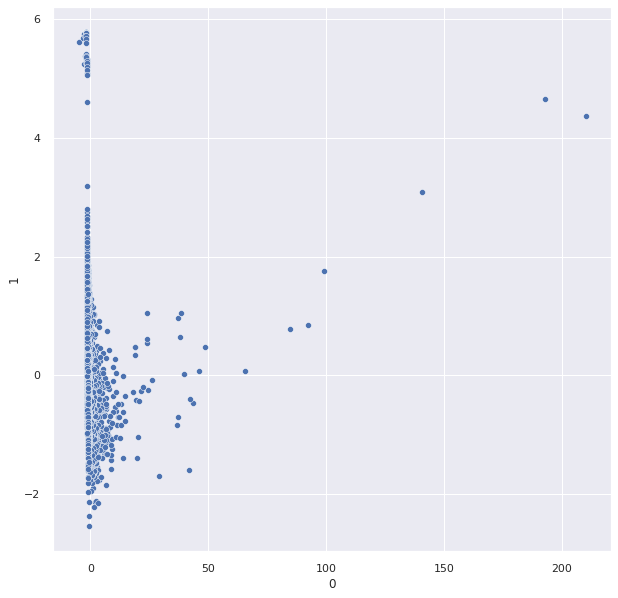

In [56]:
df_pca = pd.DataFrame(principal_component)

plt.figure(figsize=(10,10))
sns.scatterplot(x=0, y=1, data=df_pca)
plt.show()

### 4.3.2. UMAP

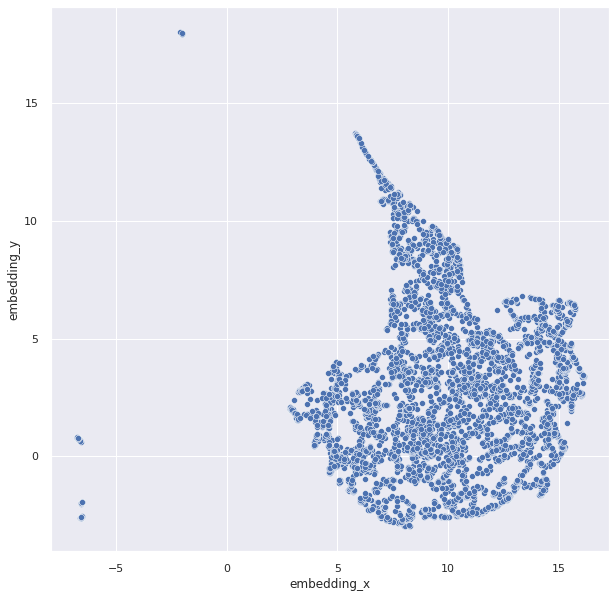

In [57]:
X_UMAP = data_space.copy()
reducer = ump.UMAP( random_state=42)
embedding = reducer.fit_transform(X_UMAP)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_pca)
plt.show()

In [58]:
df_pca.head()

0         1         2         3         4  embedding_x  embedding_y
0  2.594016  0.849771 -1.265367 -0.748346 -1.060482     7.382659     9.115162
1  0.939175 -0.427136 -0.603685  0.267577 -0.301155     8.543480     7.459044
2  4.074269 -0.755795 -0.751908  0.306797 -0.226573     7.341728    11.371250
3 -0.715561  0.404912 -0.578495 -0.466282 -0.131245     7.408540     3.557174
4 -0.940013  1.495490 -1.951392 -0.506371  0.225211     3.744881     2.859680

### 4.3.3. t-SNE

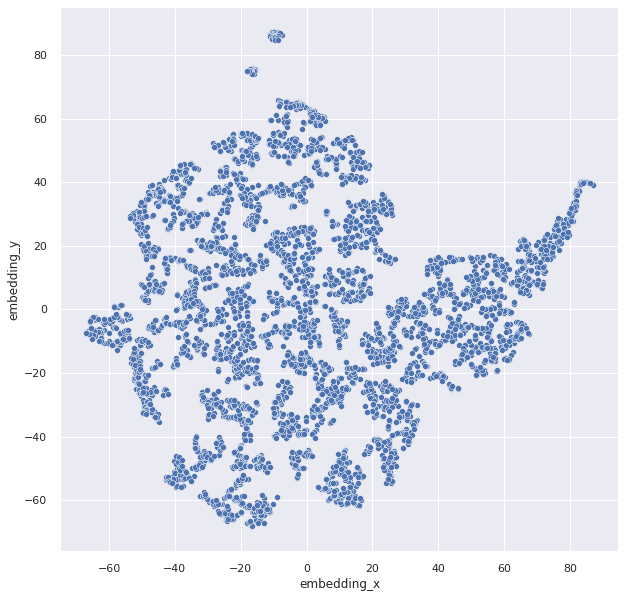

In [59]:
X_TSNE = data_space.copy()
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform(X_TSNE)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_pca)
plt.show()

### 4.3.4. Tree-based embedding

In [106]:
# training dataset
x_trees = data_space.drop(columns=['gross_revenue'], axis=1)
y_trees = data_space['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(x_trees, y_trees)

#Leaves
df_leaf = pd.DataFrame(rf_model.apply(x_trees))

#Leaves dataFrame
df_leaf.shape

(4362, 100)

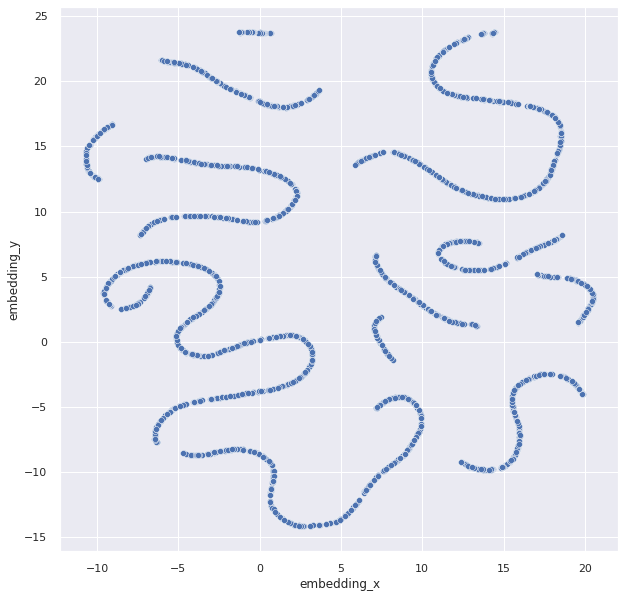

In [107]:
reducer = ump.UMAP( random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_leaf['embedding_x'] = embedding[:,0]
df_leaf['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_leaf)
plt.show()

In [115]:
df_leaf['customer_id'] = customers_to_cluster
#for i in range(len(df_leaf), 1):
#    df_leaf.loc[i,'customer_id'] = customers_to_cluster[i]

In [116]:
df_leaf.isna().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
16             0
17             0
18             0
19             0
20             0
21             0
22             0
23             0
24             0
25             0
26             0
27             0
28             0
29             0
30             0
31             0
32             0
33             0
34             0
35             0
36             0
37             0
38             0
39             0
40             0
41             0
42             0
43             0
44             0
45             0
46             0
47             0
48             0
49             0
50             0
51             0
52             0
53             0
54             0
55             0
56             0
57             0
58            

# 5. Data preparation

## 5.1. Data rescaling

In [65]:
df_rescaled = df4.copy()
df_rescaled = df_rescaled.drop(columns=['purchases', 'devolutions', 'recency_p', 'recency_d', 'quantity_p', 'quantity_d', 'invoices_p', 'invoices_d', 'avg_ticket','avg_recency_days', 'avg_basket_size', 'avg_variety', 'purchases_pday','relative_revenue', 'relative_quantity'], axis=1)

#df_rescaled = data_space.copy()

In [66]:
rs = RobustScaler()
#rs = StandardScaler()

#df_rescaled['purchases'] = rs.fit_transform( df_rescaled[['purchases']].values )
#df_rescaled['devolutions'] = rs.fit_transform( df_rescaled[['devolutions']].values )
#df_rescaled['purc_dev'] = rs.fit_transform( df_rescaled[['purc_dev']].values )
#df_rescaled['recency_p'] = rs.fit_transform( df_rescaled[['recency_p']].values )
#df_rescaled['recency_d'] = rs.fit_transform( df_rescaled[['recency_d']].values )
#df_rescaled['quantity_p'] = rs.fit_transform( df_rescaled[['quantity_p']].values )
#df_rescaled['quantity_d'] = rs.fit_transform( df_rescaled[['quantity_d']].values )

df_rescaled['gross_revenue'] = rs.fit_transform( df_rescaled[['gross_revenue']].values )
#df_rescaled['avg_ticket'] = rs.fit_transform( df_rescaled[['avg_ticket']].values )
#df_rescaled['avg_recency_days'] = rs.fit_transform( df_rescaled[['avg_recency_days']].values )
#df_rescaled['avg_basket_size'] = rs.fit_transform( df_rescaled[['avg_basket_size']].values )
#df_rescaled['avg_variety'] = rs.fit_transform( df_rescaled[['avg_variety']].values )
#df_rescaled['invoices_p'] = rs.fit_transform( df_rescaled[['invoices_p']].values )
#df_rescaled['purchases_pday'] = rs.fit_transform( df_rescaled[['purchases_pday']].values )
#df_rescaled['relative_quantity'] = rs.fit_transform( df_rescaled[['relative_quantity']].values )
#df_rescaled['relative_invoices'] = rs.fit_transform( df_rescaled[['relative_invoices']].values )

In [67]:
df_rescaled.head()

customer_id  gross_revenue  monetary_score  ticket_score  recency_score  behavior_score
0        17850       3.517857        3.723343      1.559960       0.893237        0.453063
1        13047       1.842711        3.488424      1.575717       1.901991        2.045657
2        12583       4.957356        3.856568      1.770547       2.145596        2.224704
3        13748       0.227216        2.976923      1.830795       1.030052        1.496376
4        15100      -0.010197        2.802842      2.766413       1.258218        0.000000

# 6. Feature selection

In [68]:
df6 = df_rescaled.copy()
#df6 = df_leaf.copy()

In [70]:
#df6 = df6.drop(columns=['purchases_pday','quantity_p','quantity_d','relative_revenue'],axis=0)

# 7. Hyperparameter fine tuning

There are 3 types of major problems within data problems to solve with machine learning algorithms: regression, classification and clusterization. The first two problems, regression and classification, there is a necessity to split the dataset between training and testing and there is a target variable to analyze the accuracy and precision of the model, while the clusterization problems does not have the need in dataset spliting. Because of that, there is a necessity to first determine the number of clusters which the dataset will be split, before training and finding the model.

In [143]:
df7 = df6.copy()
df7_embbed = df_leaf.copy()
#print(df7.head())
#print(df7_embbed.head())

In [121]:
tree_cols_to_drop = []
for i in range( 0, (df7_embbed.shape[1]-3),1 ):
    tree_cols_to_drop.append(i)
    i = i + 1


X_embbed = df7_embbed.drop(columns=tree_cols_to_drop, axis=1)
X_embbed = X_embbed.drop(columns=['customer_id'], axis=1)
customers_to_cluster = df7['customer_id'].to_list()
X = df7.drop(columns=['customer_id'], axis=0)
print(X.head())
print(X_embbed.head())

   gross_revenue  monetary_score  ticket_score  recency_score  behavior_score
0       3.517857        3.723343      1.559960       0.893237        0.453063
1       1.842711        3.488424      1.575717       1.901991        2.045657
2       4.957356        3.856568      1.770547       2.145596        2.224704
3       0.227216        2.976923      1.830795       1.030052        1.496376
4      -0.010197        2.802842      2.766413       1.258218        0.000000
   embedding_x  embedding_y
0    14.985906    18.420183
1    13.926341    11.097065
2    10.832656    19.741858
3    15.559465    -4.975129
4     4.064472   -13.964382


## 7.1. Cluster evaluation metrics - (KMeans model)

Clustering problems in data science do not have a target variable, which means that the clustering error and precision depends on the analyst's input. In order to reduce the subjectiviy of the analyst's choice, there are some metrics to evaluate how many cluster the datset must be divided. Two metrics are the within-cluster sum of square (WSS) or the sillhouette score.

The WSS metric measures the compactness of a cluster, which means that for a given point within a cluster, the distances of each point inside that cluster must be minimal, while the distance of the points to the nearest cluster should be maximum. However, the WSS does not measure the distances between the clusters. This is a problem, since we could have 2 extremely compact cluster with overlap and the WSS metric would result in great clusterization. 


To solve this problem, we can use the silhouette score, which measures the both the separation of the cluster and its compactness. 

**WSS Theory**: the method define one centroid for each cluster (the number of cluster is defined by the analyst), then it calculates the distances between each point within the cluster and the centroid and it is done for each cluster. Then, all distances within it cluster is summed, and the lowest is the sum, the more compact it is the cluster. Since, for the sum to be low, the distances between the points and the centroid must also be low. 

**Silhouette score Theory**: the silhouette score measures the distance between a point for a given cluster and all other points and this distance is calculated for all points inside the cluster, not only the centroid. The mean distance is calculated for every point, then the distance for a every point inside the cluster A is calculated between the point inside A and all other points inside B, and the mean distance is calculated. This is done for all clusters, remembering that the mean distance between cluster A and B is equal to the mean distance between B and A. Afterwards, we have to know which is the closest cluster for the cluster A, and it is calculated by analyzing which mean distance have the minimum value. With the minimum distance between clusters, we calculate the score by subtracting the distance within the cluster from the distance between clusters and divide it by the maximum value between both of them. The value calculated is the silhouette score, which measure how distant the clusters are between each other and how compact one cluster is. The metric can be interpretated by analyzing the values of the distances. For a positive score, with maximum value of 1, it means that the clusters are compact and distant from each other, however the closest to -1 means that the clusters are large and/or overlapping.

### 7.1.1. Within-cluster sum of square (WSS)

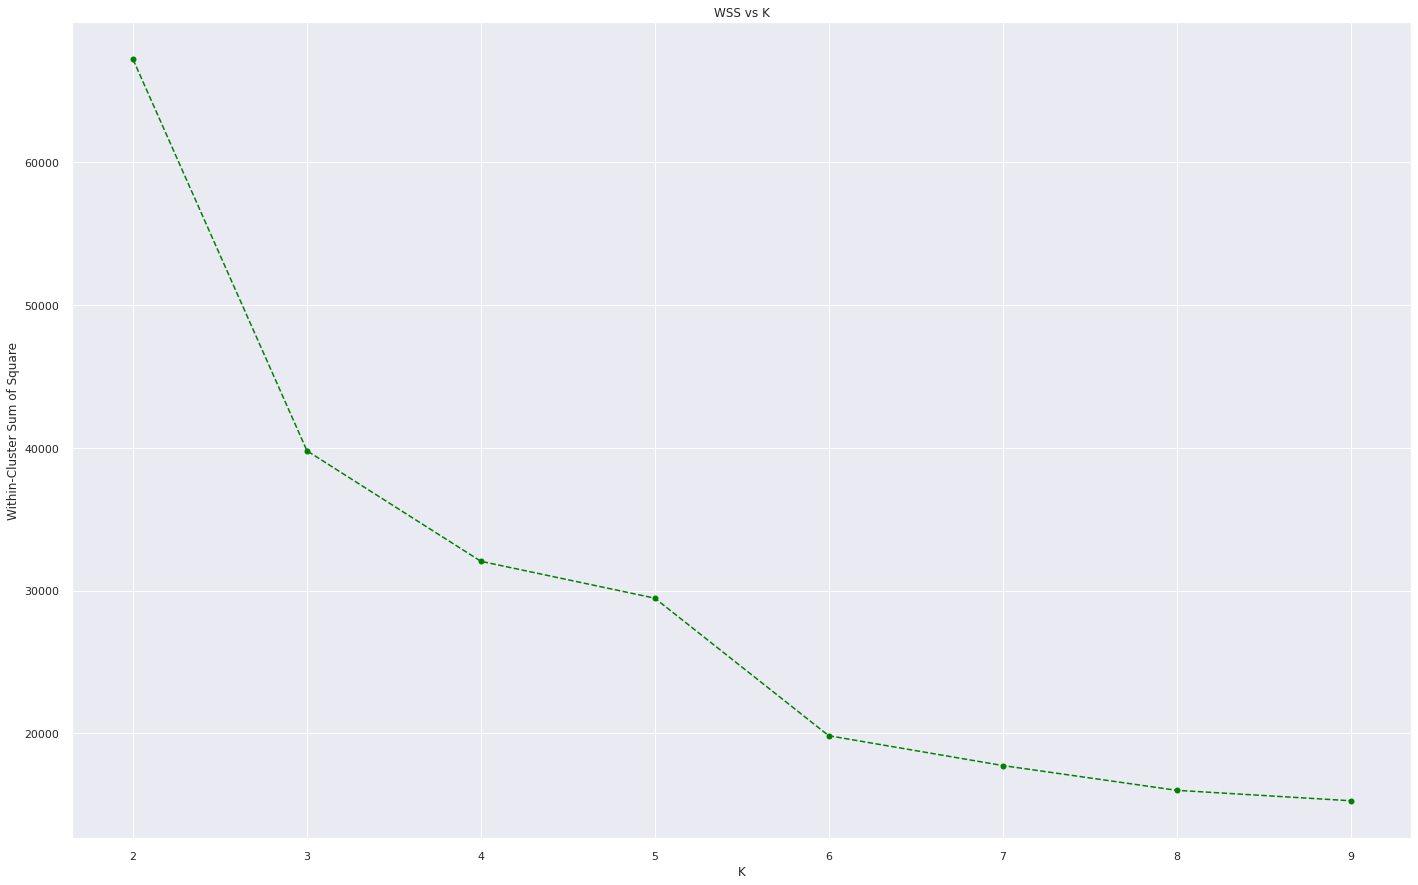

In [87]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

wss = []
for k in n_clusters:
    
    #print(k)
    
    kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

plt.plot(n_clusters, wss, linestyle='--', marker='o', color='green')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')
plt.show()

Alternatively, it is possible to use the methods within the yellowbrick library

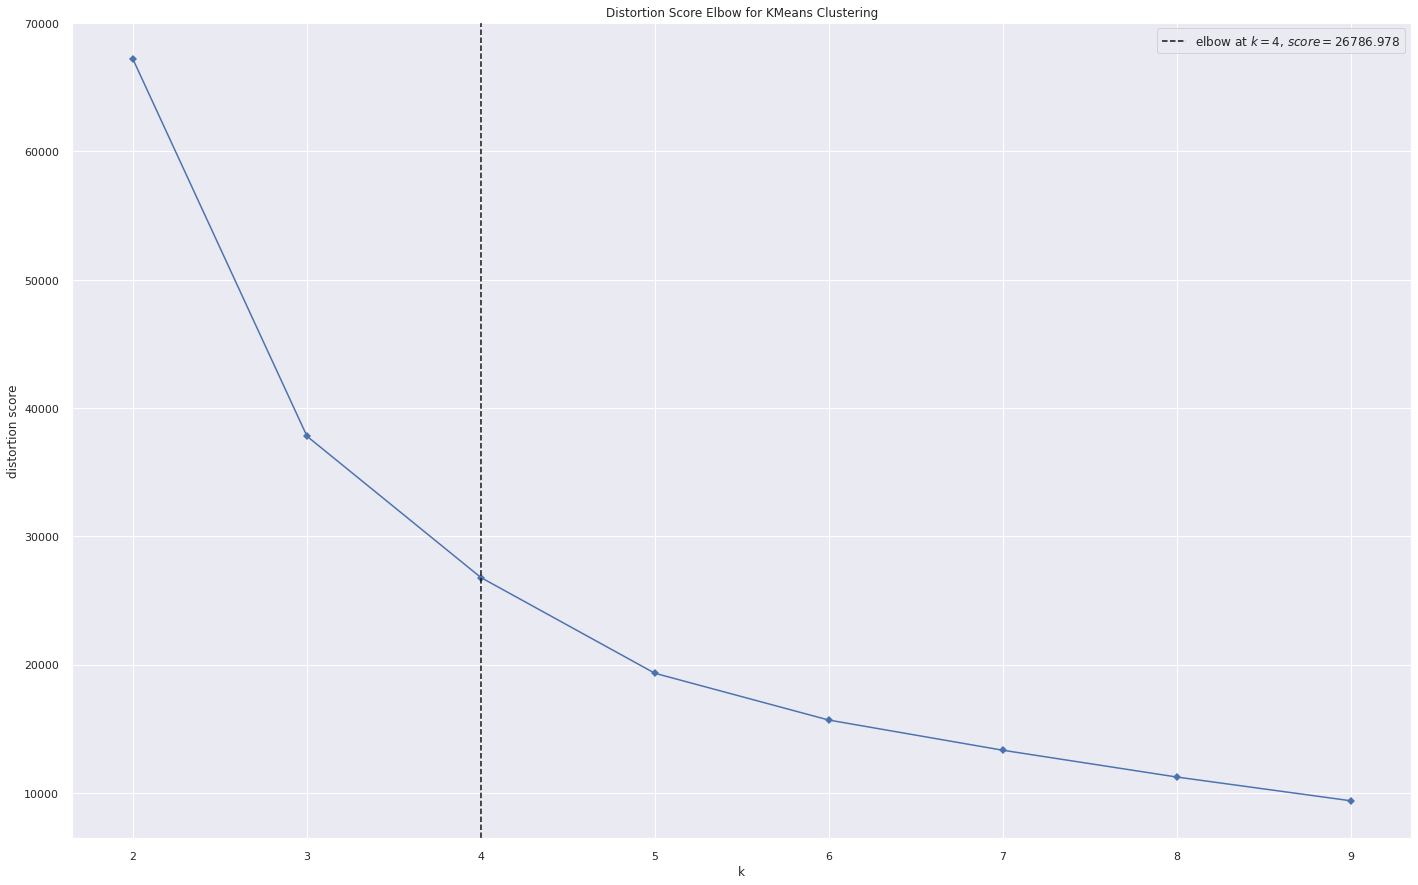

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show()

### 7.1.2. Sillhouette score

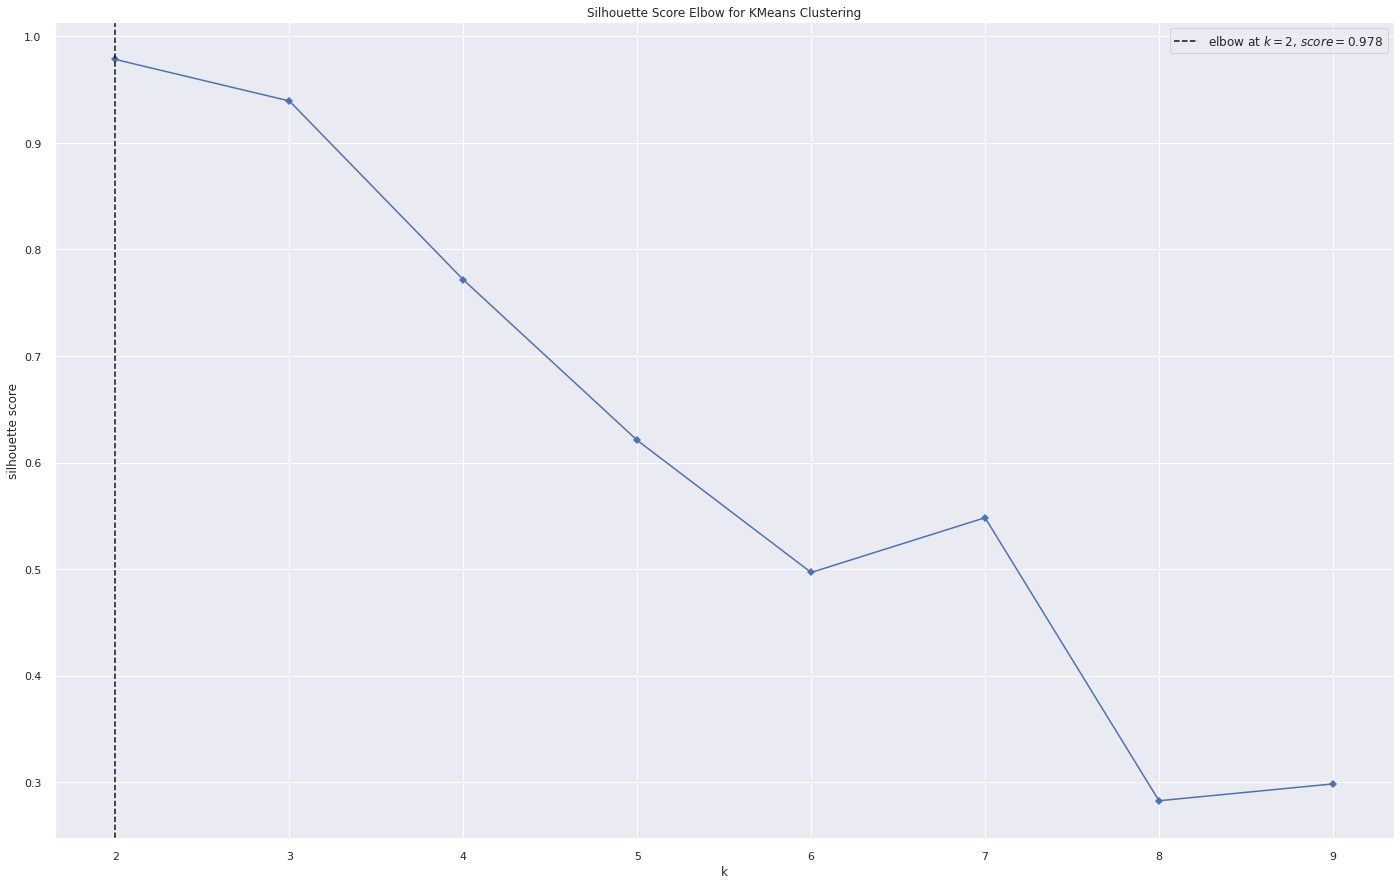

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [84]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False, metric='silhouette')
kmeans.fit(X)
kmeans.show()

### 7.1.3. Silhouette analysis

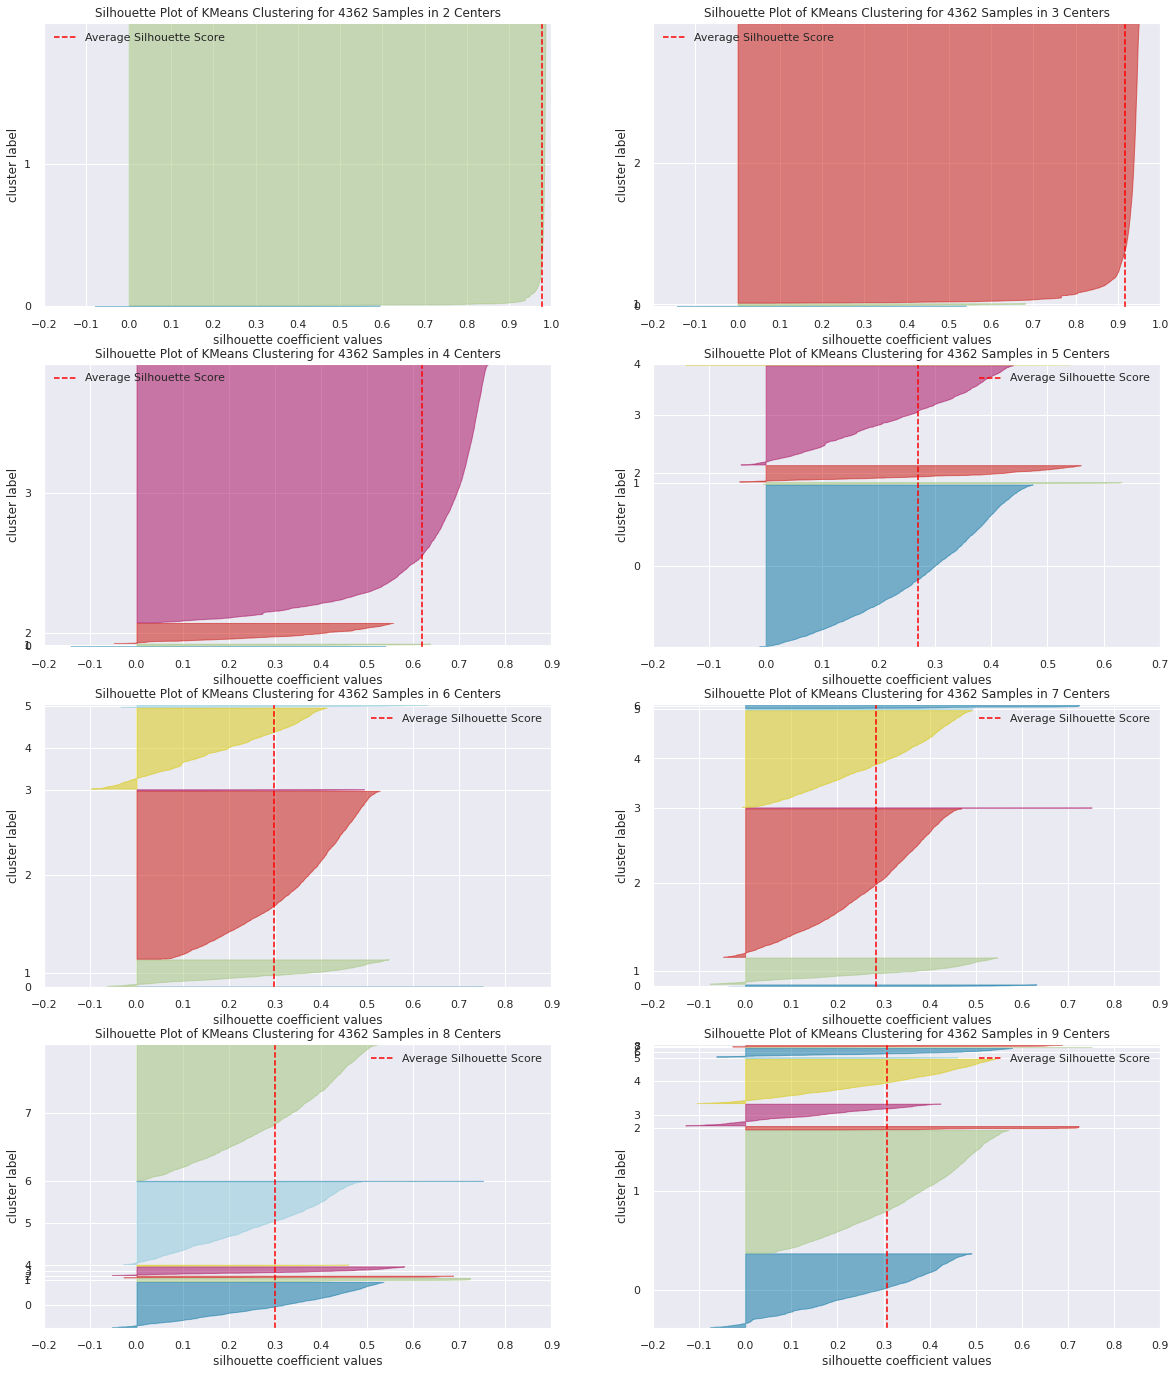

In [85]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots(4, 2, figsize=(20,24))

for k in n_clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100,random_state=42)
    
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

## 7.2. Cluster evaluation metrics - (KMeans model on embbeded dataset)

In [122]:
X_embbed.isna().sum()
X_embbed.shape[0]

4362

### 7.2.1 Whithin-cluster sum of square (WSS)

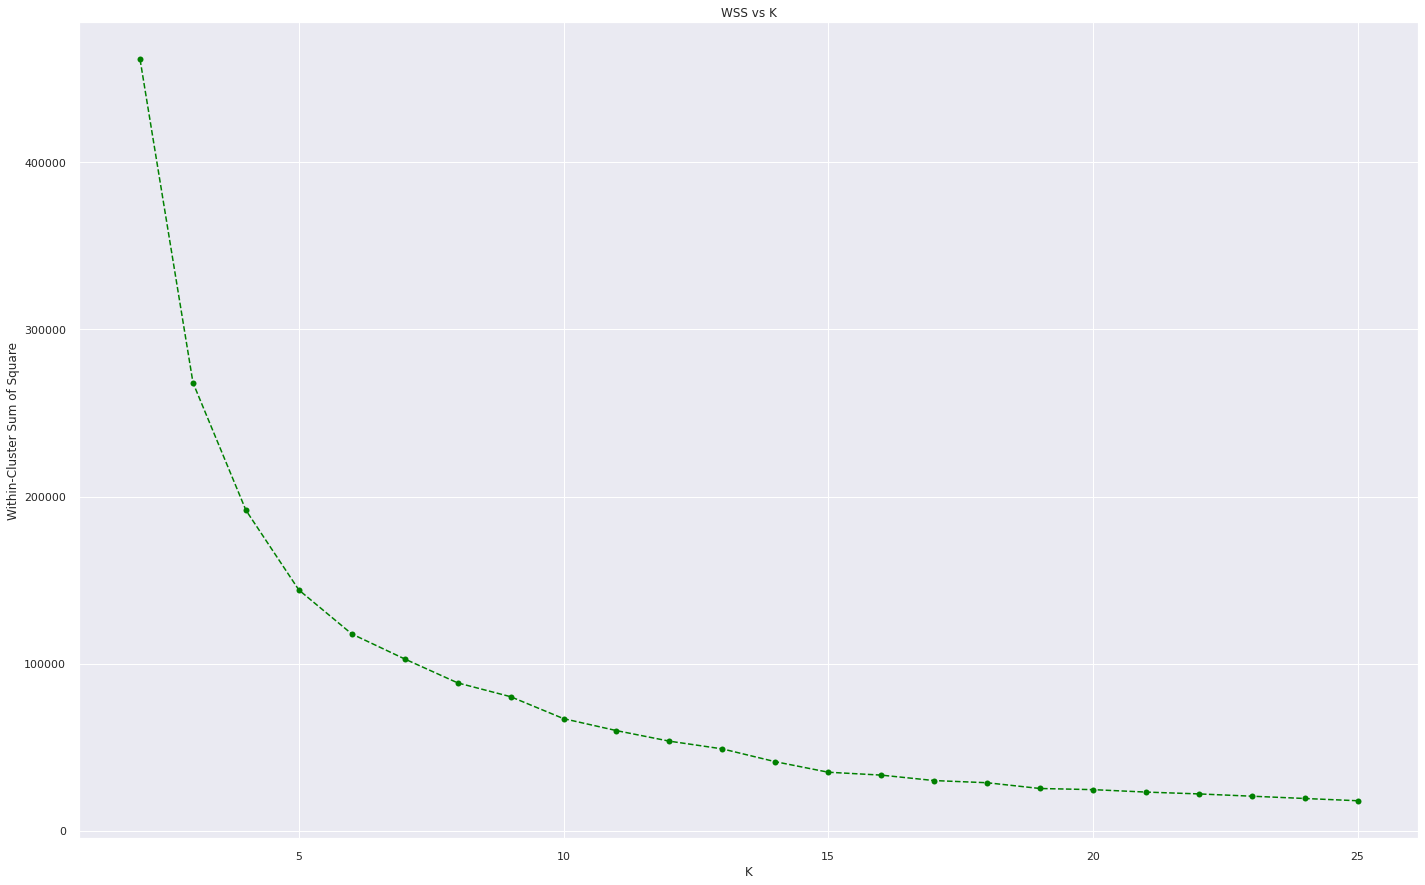

In [130]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

wss = []
for k in n_clusters:
    
    #print(k)
    
    kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    
    kmeans.fit(X_embbed)
    
    wss.append(kmeans.inertia_)

plt.plot(n_clusters, wss, linestyle='--', marker='o', color='green')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')
plt.show()

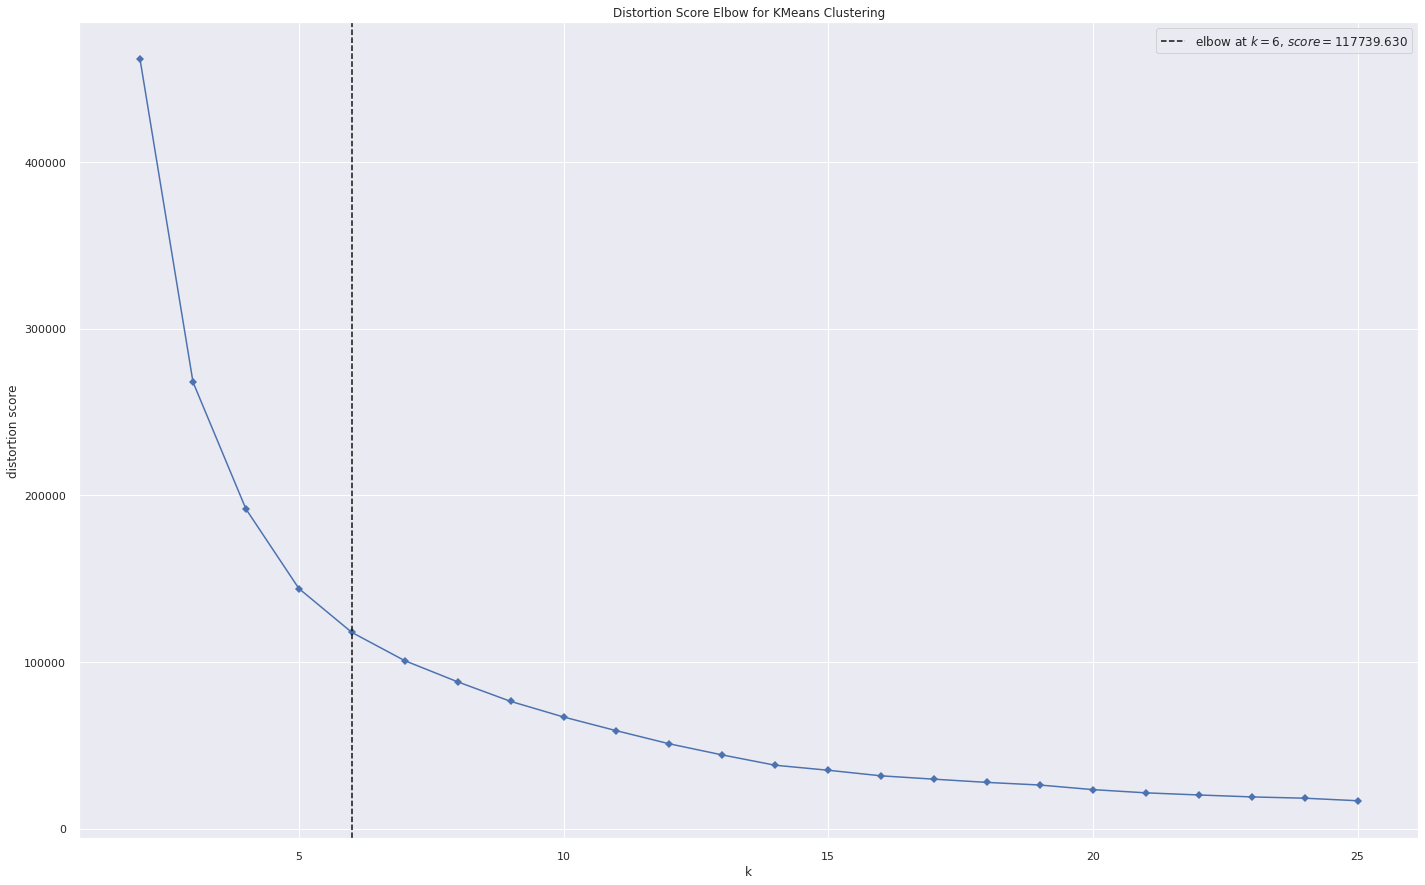

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [131]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False)
kmeans.fit(X_embbed)
kmeans.show()

### 7.2.2. Silhouette score

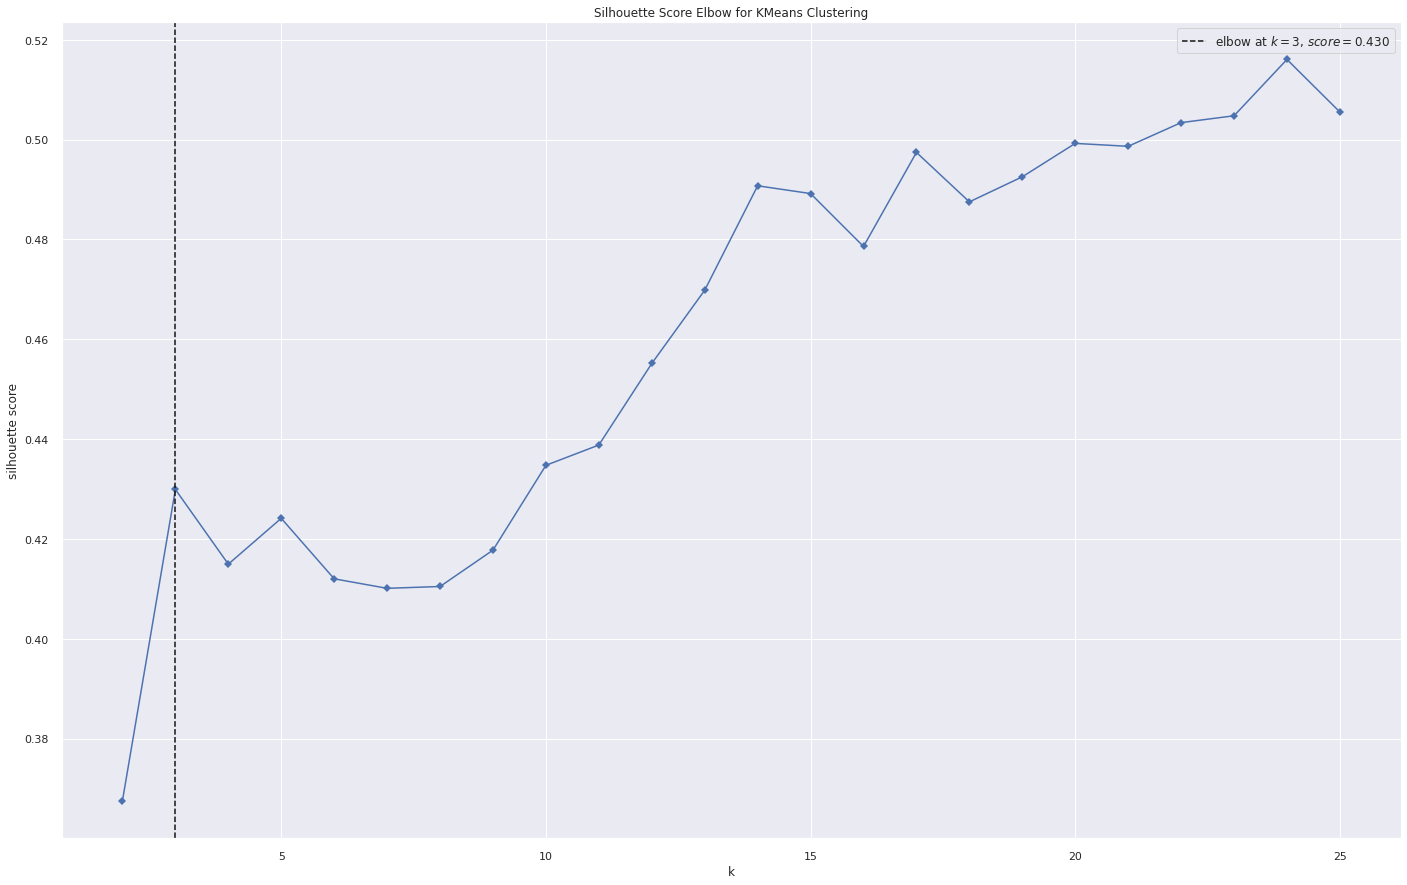

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [132]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False, metric='silhouette')
kmeans.fit(X_embbed)
kmeans.show()

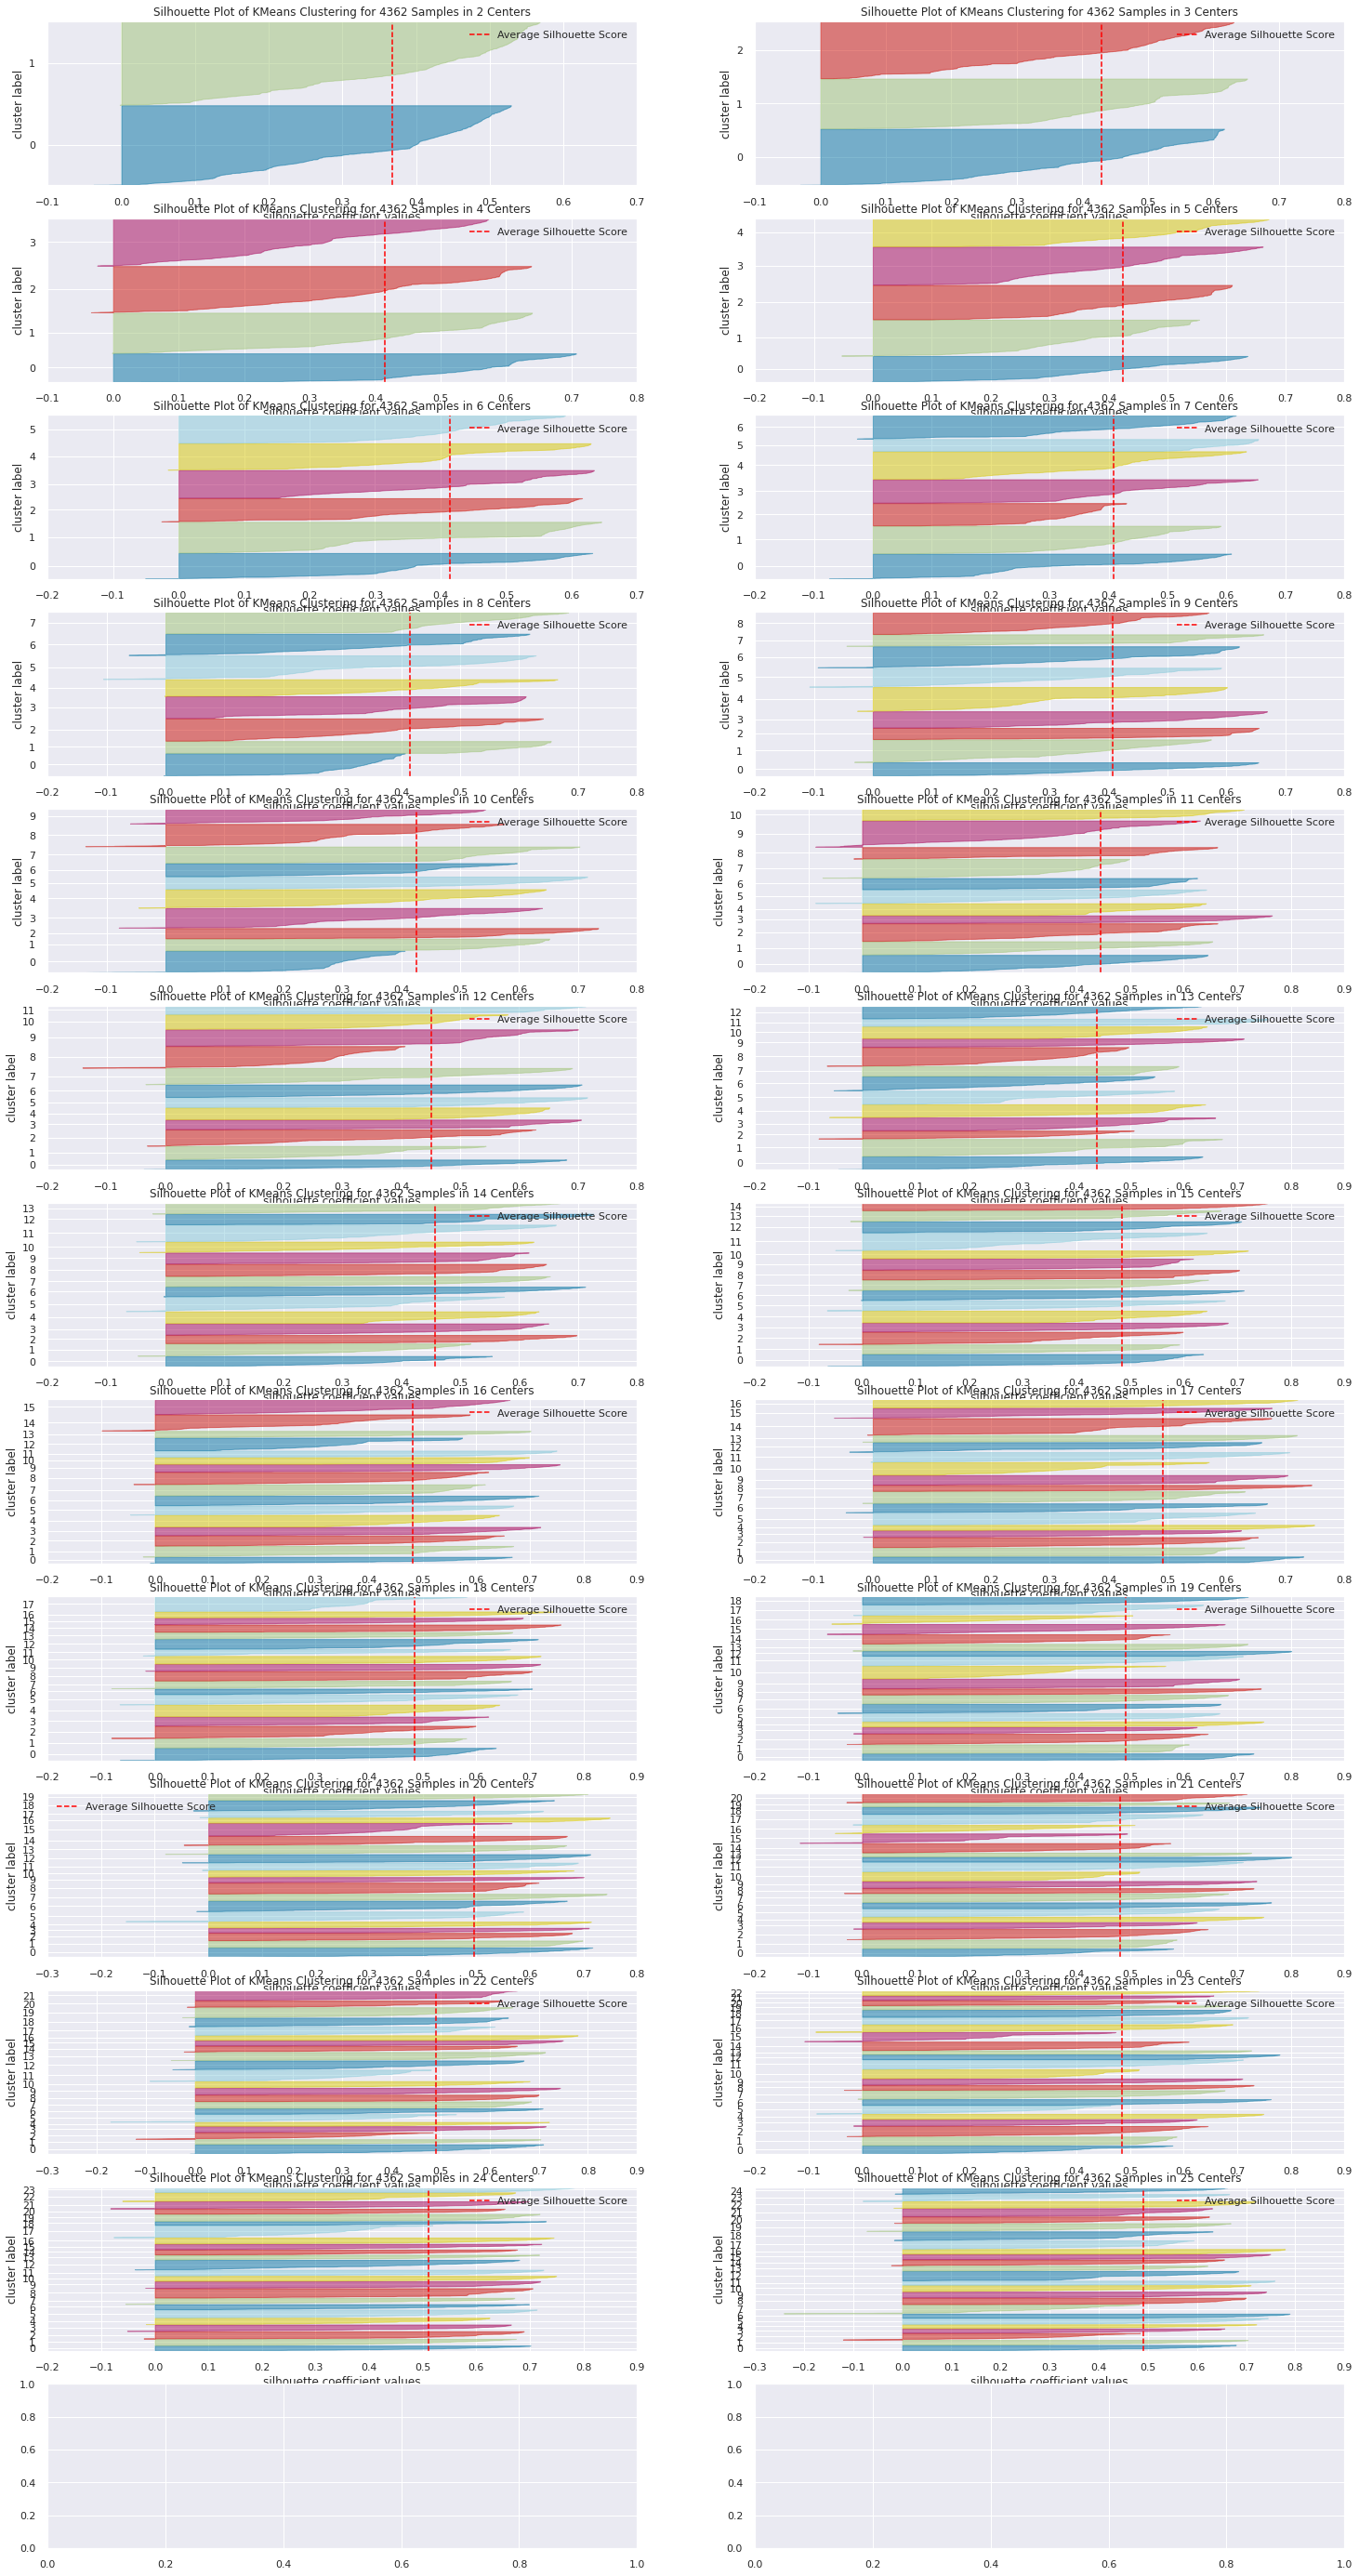

In [136]:
#n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots(13, 2, figsize=(25,50))

for k in n_clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100,random_state=42)
    
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X_embbed )
    visualizer.finalize()

## 7.3. Cluster evaluation metrics (Gaussian Mixture Model)

# 8. Model training

## 8.1. K-Means model

In [383]:
k = 4

kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X)
print('WSS Value for original data: {}'.format(kmeans.inertia_))

labels = kmeans.labels_

WSS Value for original data: 32046.728126802907


### 8.1.2. Cluster validation

### WSS

In [137]:
print('WSS Value for original data: {}'.format(kmeans.inertia_))

WSS Value for original data: 17375.37109375


### Silhouette score

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

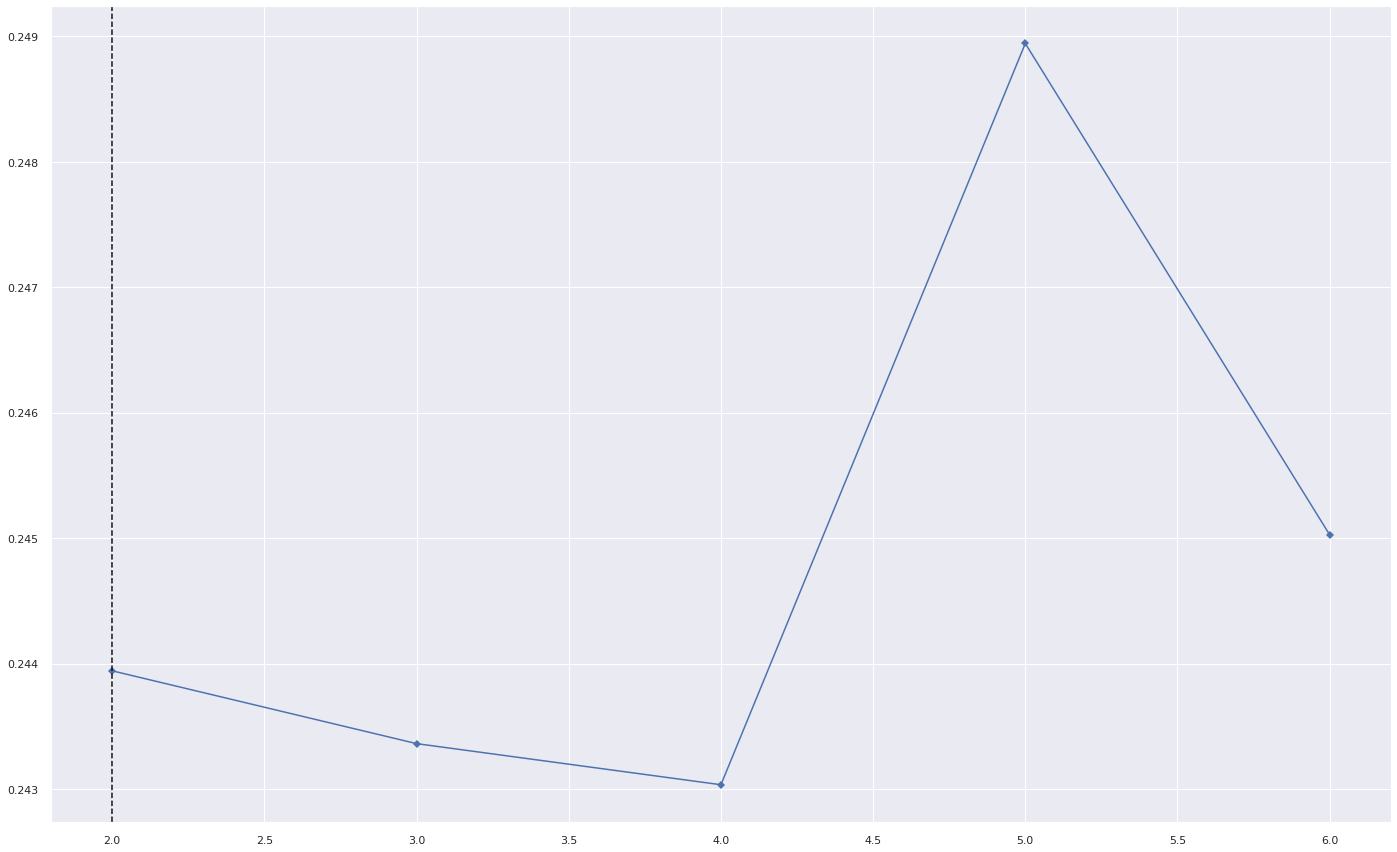

In [138]:
kmeans_silhouette = KElbowVisualizer(kmeans, k=6, timings=False, metric='silhouette')
kmeans_silhouette.fit(X)


## 8.2. K-Means model on embbeded dataset

### WSS

In [140]:
k = 20

kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X_embbed)
print('WSS Value for embbeded data: {}'.format(kmeans.inertia_))

labels = kmeans.labels_

WSS Value for embbeded data: 24570.58984375


### Silhouette score

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

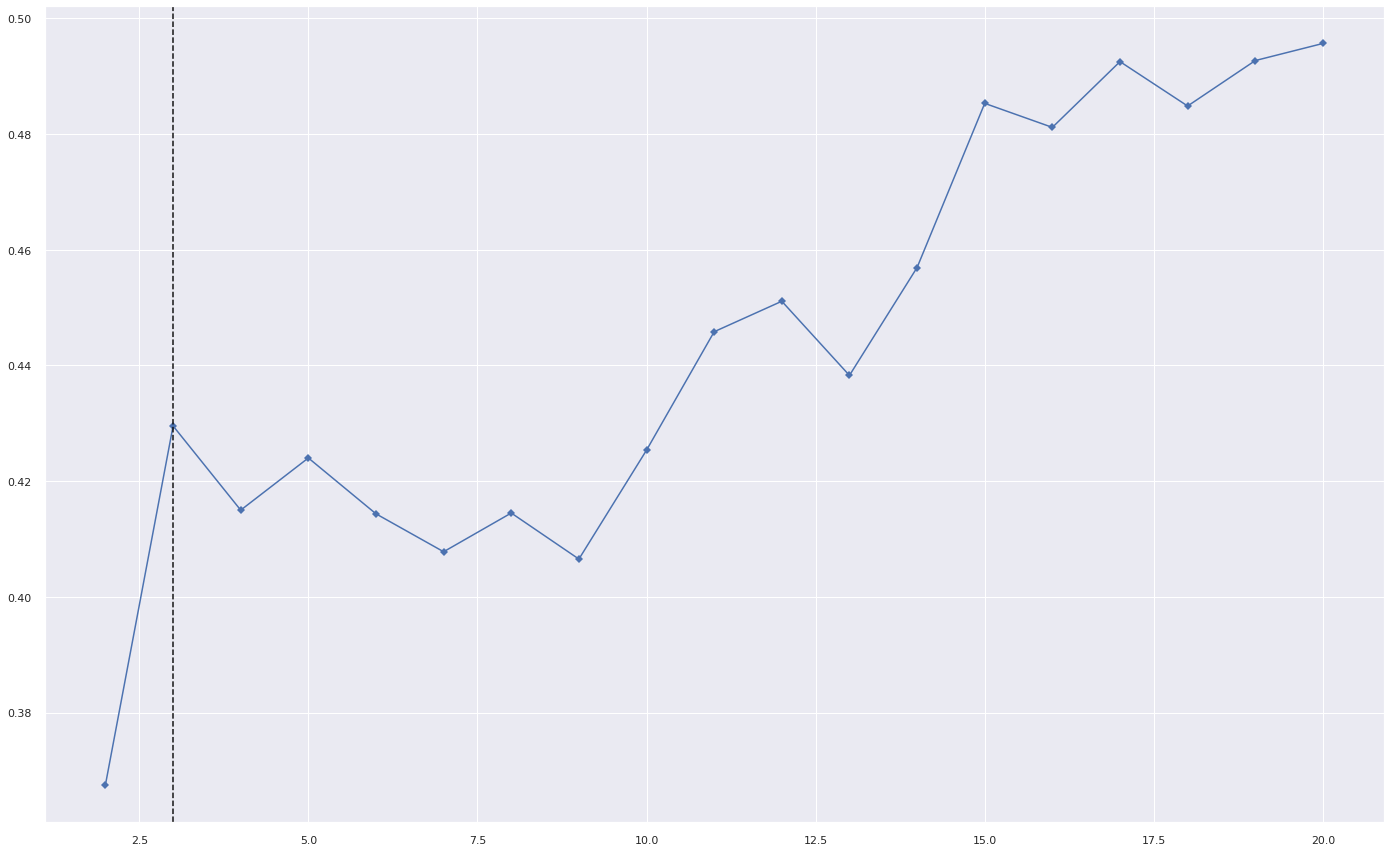

In [141]:
kmeans_silhouette = KElbowVisualizer(kmeans, k=k, timings=False, metric='silhouette')
kmeans_silhouette.fit(X_embbed)

# 9. Cluster analysis

## 9.1. K-Means model

In [387]:
df9 = df_ref.copy()
df9 = df9[df9['customer_id'].isin(customers_to_cluster)]
df9['cluster'] = labels
df7['cluster'] = labels
df9.head()


customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d  avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score  cluster
0        17850    5391.21       102.58      372.0      302.0        35.0        21.0        34.0         1.0   18.152222        124.333333        50.970588     8.735294       17.000000        5288.63          0.962656           0.250000        3.723343      1.559960       0.893237        0.453063        0
1        13047    3237.54       158.44       31.0       31.0       132.0         6.0        10.0         8.0   18.822907         26.642857       139.100000    17.200000        0.029155        3079.10          0.906690           0.913043        3.488424      1.575717       1.901991        2.045657        3
2        12583    7281.38        94.04        2.0       56.0      1569.0        50.0        15.0         3.0   29.479271         20.722222       337.333333    16.466667        0.040323        7187.34          0.974499           0.938233        3.856568      1.770547       2.145596        2.224704        0
3        13748     948.25         0.00       95.0      365.0       169.0        -0.0         5.0         0.0   33.866071         93.250000        87.800000     5.600000        0.017921         948.25          1.000000           1.000000        2.976923      1.830795       1.030052        1.496376        3
4        15100     876.00       240.90      333.0      330.0        48.0        22.0         3.0         3.0  292.000000         62.166667        26.666667     1.000000        0.073171         635.10          0.568627           0.371429        2.802842      2.766413       1.258218        0.000000        3

### 9.1.1. Visualization Inspection

In [388]:
#fig = px.scatter_3d(df9, x='recency_p', y='freq_p', z='purchases', color='cluster')
#fig.show()


### 9.1.2. Pair visualization

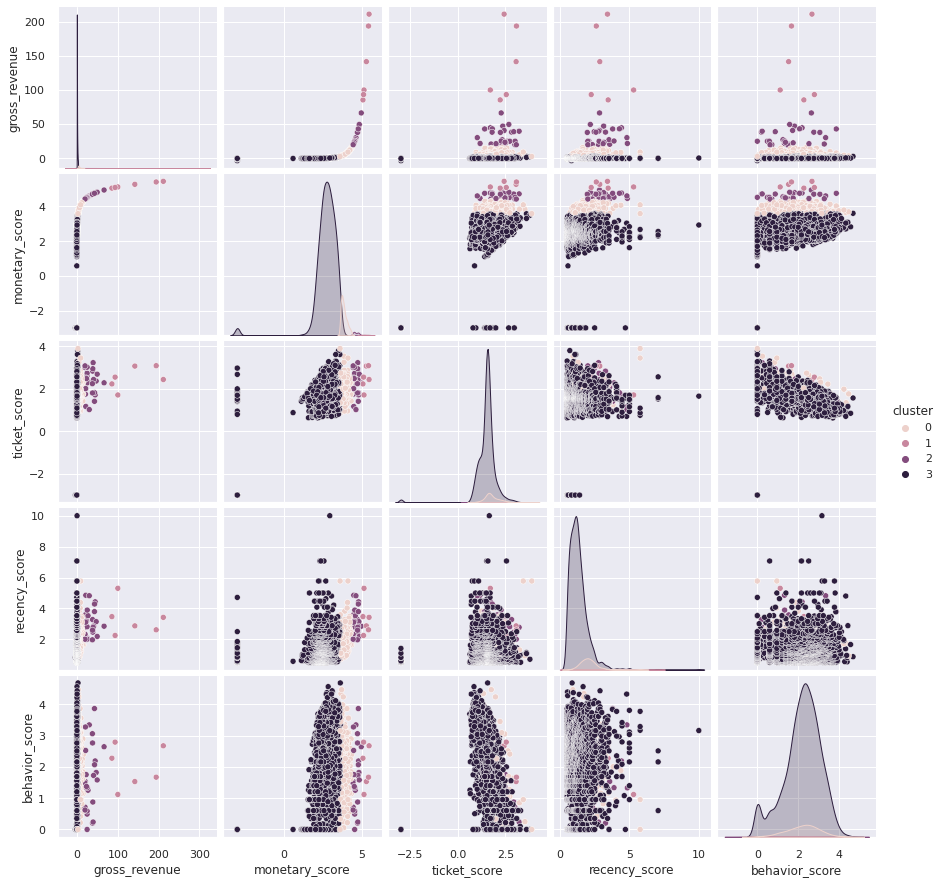

In [389]:
df_viz = df7.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

plt.show()

### 9.1.3. UMAP - t-SNE

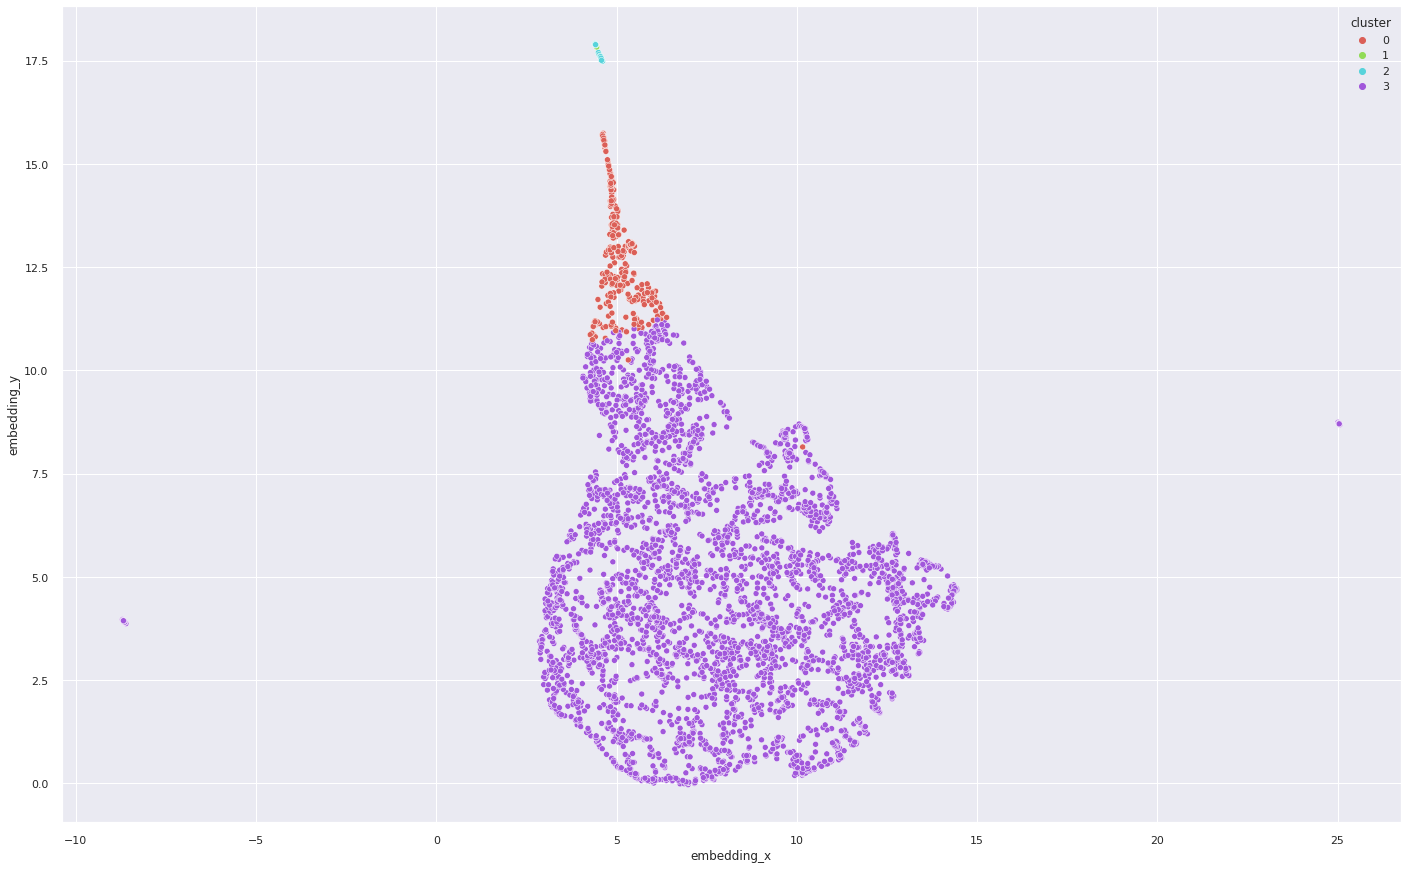

In [390]:
df_viz1 = df7.drop(columns=['customer_id'], axis=1)

reducer = ump.UMAP(n_neighbors=25, random_state=42)
embedding = reducer.fit_transform(X)

df_viz1['embedding_x'] = embedding[:,0]
df_viz1['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y', hue='cluster', palette=sns.color_palette('hls',n_colors=len(df_viz1['cluster'].unique())), data=df_viz1)
plt.show()

### 9.1.4. Cluster profile

The profile of each cluster can be represented as a persona, and the persona is the mean or median behavior of all other customers inside the cluster

In [391]:
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum()), 3)

df_avg_purchases = round(df9[['purchases', 'cluster']].groupby('cluster').mean().reset_index(), 2)
df_avg_devolutions = round(df9[['devolutions', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_relation = round(df9[['purc_dev','cluster']].groupby('cluster').mean().reset_index() , 2)

df_avg_recency_p = round(df9[['cluster', 'recency_p']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_d = round(df9[['cluster', 'recency_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_frequency_p = round(df9[['cluster','quantity_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_frequency_d = round(df9[['cluster','quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_ticket = round(df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_days = round(df9[['cluster','avg_recency_days']].groupby('cluster').mean().reset_index(), 2)
#df_purchases_pday = round(df9[['cluster','purchases_pday']].groupby('cluster').mean().reset_index(), 2)

df_cluster = pd.merge(df_cluster, df_avg_purchases, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_devolutions, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_relation, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_p, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_frequency_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_frequency_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_purchases_pday, on='cluster', how='inner')

df_cluster

cluster  customer_id  perc_customer  purchases  devolutions  recency_p  recency_d  quantity_p  avg_ticket  avg_recency_days
0        0          313          7.176    7716.27       247.83      21.79     141.79      802.59       68.77             29.48
1        1            6          0.138  186755.55      4573.57       7.17      51.83    15125.17      266.48             10.14
2        2           28          0.642   45591.04      2976.39       6.75      54.68     6364.75      191.11             12.96
3        3         4015         92.045     937.75        28.66     100.36     293.76      168.61       29.10            100.32

In [392]:
df_avg_monetary_score = round(df7[['cluster','monetary_score']].groupby('cluster').mean().reset_index(), 2)
df_avg_ticket_score = round(df7[['cluster','ticket_score']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_score = round(df7[['cluster','recency_score']].groupby('cluster').mean().reset_index(), 2)
df_avg_behavior_score = round(df7[['cluster','behavior_score']].groupby('cluster').mean().reset_index(), 2)

df_cluster = pd.merge(df_cluster, df_avg_monetary_score, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_ticket_score, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_score, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_behavior_score, on='cluster', how='inner')

df_cluster

cluster  customer_id  perc_customer  purchases  devolutions  recency_p  recency_d  quantity_p  avg_ticket  avg_recency_days  monetary_score  ticket_score  recency_score  behavior_score
0        0          313          7.176    7716.27       247.83      21.79     141.79      802.59       68.77             29.48            3.83          1.79           2.05            2.23
1        1            6          0.138  186755.55      4573.57       7.17      51.83    15125.17      266.48             10.14            5.23          2.51           3.32            2.01
2        2           28          0.642   45591.04      2976.39       6.75      54.68     6364.75      191.11             12.96            4.60          2.30           2.99            1.62
3        3         4015         92.045     937.75        28.66     100.36     293.76      168.61       29.10            100.32            2.68          1.50           1.32            2.18

In [395]:
df9[df9['cluster'] == 0]

customer_id  purchases  devolutions  recency_p  recency_d  quantity_p  quantity_d  invoices_p  invoices_d   avg_ticket  avg_recency_days  avg_basket_size  avg_variety  purchases_pday  gross_revenue  relative_revenue  relative_quantity  monetary_score  ticket_score  recency_score  behavior_score  cluster
0           17850    5391.21       102.58      372.0      302.0        35.0        21.0        34.0         1.0    18.152222        124.333333        50.970588     8.735294       17.000000        5288.63          0.962656           0.250000        3.723343      1.559960       0.893237        0.453063        0
2           12583    7281.38        94.04        2.0       56.0      1569.0        50.0        15.0         3.0    29.479271         20.722222       337.333333    16.466667        0.040323        7187.34          0.974499           0.938233        3.856568      1.770547       2.145596        2.224704        0
5           15291    4668.30        71.79       25.0      172.0       508.0        27.0        15.0         5.0    45.323301         21.941176       140.200000     6.866667        0.042980        4596.51          0.969709           0.899065        3.662428      1.957352       2.087816        1.459004        0
6           14688    5630.87       523.49        7.0        7.0       579.0       281.0        21.0         6.0    17.219786         17.761905       172.428571    15.571429        0.057221        5107.38          0.829880           0.346512        3.708198      1.537058       2.308668        0.685739        0
7           17809    5411.91       784.29       16.0       16.0       961.0        41.0        12.0         3.0    88.719836         31.083333       171.416667     5.083333        0.033520        4627.62          0.746848           0.918164        3.665358      2.249051       1.765470        0.968453        0
9           14527    8508.82       797.44        2.0        8.0       198.0         3.0        55.0        31.0     8.753930          5.828125        37.981818    17.672727        0.149457        7711.38          0.828623           0.970149        3.887132      1.243233       3.826919        2.005384        0
15          12431    6487.45        71.06       35.0      136.0      1130.0        44.0        15.0         3.0    27.606170         23.312500       193.733333    15.666667        0.044248        6416.39          0.978330           0.925043        3.807291      1.742036       2.028081        2.162901        0
21          13767   17220.36       274.65        2.0       29.0      1130.0        22.0        37.0        15.0    46.794457          8.880952       197.891892     9.945946        0.099462       16945.71          0.968602           0.961806        4.229060      1.971224       3.181270        1.858829        0
25          15513   14758.22       238.14       33.0       31.0       912.0       160.0        19.0         3.0    47.916299         20.722222       300.473684    16.210526        0.055718       14520.08          0.968240           0.701493        4.161969      1.981513       2.145596        1.643421        0
31          17920    4204.10         0.00        4.0      365.0       501.0        -0.0        17.0         0.0     6.040374         21.941176       148.000000    40.941176        0.045946        4204.10          1.000000           1.000000        3.623673      1.082094       2.087816        3.224321        0
39          14849    7930.54        26.26       21.0       57.0       467.0        37.0        25.0         3.0    20.439536         23.312500       227.760000    15.520000        0.070822        7904.28          0.993399           0.853175        3.897862      1.611501       2.028081        2.018664        0
41          16210   21086.30         0.00        1.0      365.0      2686.0        -0.0        18.0         0.0   171.433333         21.941176       419.944444     6.833333        0.048257       21086.30          1.000000           1.000000        4.324000      2.535125    

## 9.2. K-Means on embbeded dataset

In [146]:
df9_embbed = df_ref.copy()
df9_embbed = df9_embbed[df9_embbed['customer_id'].isin(customers_to_cluster)]
df9_embbed['cluster'] = labels
df7_embbed['cluster'] = labels
df7_embbed.head()


0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99  embedding_x  embedding_y  customer_id  cluster
0  5134  5192  5110  5206  5138  5205  5108  5119  5188  5199  5195  5131  5106  5121  5152  5076  5080  5115  5116  5138  5200  5091  5131  5171  5140  5147  5167  5156  5060  5127  5203  5277  5135  5154  5126  5223  5159  5224  5087  5169  5107  5083  5147  5176  5165  5084  5181  5105  5150  5168  5183  5152  5164  5103  5172  5160  5114  5146  5085  5161  5179  5131  5151  5166  5155  5133  5175  5068  5113  5147  5107  5121  5073  5101  5131  5145  5109  5158  5172  5145  5183  5156  5162  5182  5133  5049  5104  5166  5082  5125  5209  5120  5187  5126  5123  5114  5110  5162  5176  5164    14.985906    18.420183        17850        4
1  4782  4820  4735  4847  4782  4844  4750  4742  4822  4844  4845  4771  4740  4760  4808  4701  4723  4755  4755  4785  4838  4720  4787  4798  4807  4784  4813  4820  4695  4761  4821  4899  4781  4799  4788  4862  4774  4851  4711  4832  4774  4767  4821  4829  4815  4752  4823  4748  4801  4803  4822  4792  4794  4753  4822  4824  4763  4800  4704  4789  4814  4747  4775  4804  4802  4728  4831  4744  4769  4805  4748  4769  4711  4754  4787  4792  4753  4788  4797  4807  4834  4839  4810  4830  4758  4699  4760  4799  4713  4752  4848  4769  4818  4774  4748  4736  4763  4817  4847  4796    13.926341    11.097065        13047       10
2  5244  5308  5248  5322  5239  5345  5223  5237  5299  5314  5316  5245  5216  5227  5282  5192  5206  5232  5236  5254  5336  5200  5240  5283  5264  5256  5273  5273  5188  5235  5312  5391  5249  5263  5223  5347  5264  5337  5213  5289  5223  5207  5256  5283  5292  5208  5293  5218  5266  5297  5308  5288  5285  5226  5269  5280  5232  5243  5192  5268  5297  5249  5270  5287  5278  5256  5295  5204  5237  5274  5224  5250  5193  5217  5256  5255  5224  5297  5294  5268  5302  5261  5286  5290  5253  5190  5217  5277  5201  5253  5325  5233  5280  5242  5242  5229  5228  5264  5291  5286    10.832656    19.741858        12583       12
3  3327  3323  3246  3374  3304  3346  3268  3298  3336  3354  3397  3309  3255  3319  3308  3273  3285  3293  3272  3307  3329  3269  3372  3291  3345  3330  3318  3331  3260  3258  3302  3375  3275  3328  3310  3425  3279  3374  3235  3325  3289  3242  3294  3331  3246  3309  3315  3282  3323  3332  3361  3315  3271  3300  3352  3335  3289  3339  3265  3353  3304  3252  3313  3341  3329  3267  3361  3295  3320  3279  3292  3308  3254  3305  3354  3333  3305  3275  3306  3292  3366  3370  3308  3341  3329  3281  3283  3327  3265  3265  3338  3259  3349  3367  3237  3298  3305  3344  3395  3345    15.559465    -4.975129        13748        8
4  2655  2677  2579  2705  2602  2705  2642  2625  2639  2682  2733  2661  2597  2647  2669  2651  2610  2644  2637  2613  2667  2620  2711  2626  2704  2691  2657  2673  2603  2576  2642  2696  2623  2661  2614  2751  2605  2685  2560  2676  2648  2618  2637  2668  2601  2670  2640  2633  2649  2669  2706  2672  2615  2661  2671  2680  2628  2664  2611  2698  2667  2620  2667  2666  2658  2618  2675  2609  2662  2611  2631  2638  2634  2649  2687  2689  2677  2610  2644  2649  2695  2713  2606  2659  2646  2627  2622  2671  2600  2662  2621  2606  2722  2710  2594  2636  2597  2710  2759  2716     4.064472   -13.964382        15100        0

### 9.2.1. Visualization inspection

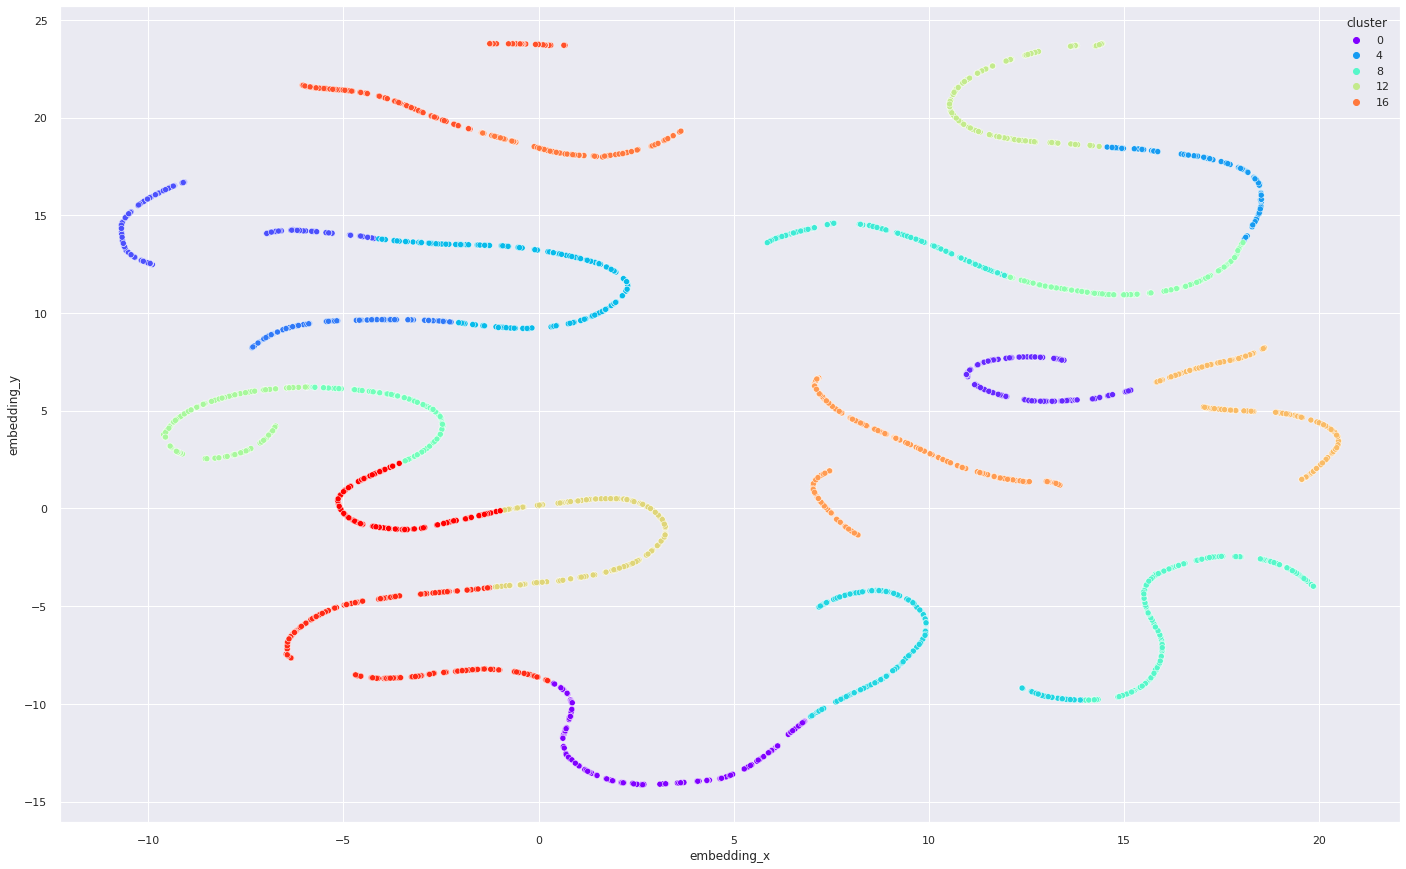

In [149]:
sns.scatterplot(x=df7_embbed['embedding_x'], y=df7_embbed['embedding_y'], hue=df7_embbed['cluster'], data=df7_embbed, palette='rainbow')
plt.show()

### 9.2.2.

In [158]:
df_cluster2 = df9_embbed[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster2['perc_customer'] = round(100*(df_cluster2['customer_id'] / df_cluster2['customer_id'].sum()), 3)

df_avg_purchases = round(df9_embbed[['purchases', 'cluster']].groupby('cluster').mean().reset_index(), 2)
df_avg_devolutions = round(df9_embbed[['devolutions', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_relation = round(df9_embbed[['purc_dev','cluster']].groupby('cluster').mean().reset_index() , 2)

df_avg_recency_p = round(df9_embbed[['cluster', 'recency_p']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_d = round(df9_embbed[['cluster', 'recency_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_frequency_p = round(df9_embbed[['cluster','quantity_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_frequency_d = round(df9_embbed[['cluster','quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_ticket = round(df9_embbed[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_days = round(df9_embbed[['cluster','avg_recency_days']].groupby('cluster').mean().reset_index(), 2)
#df_purchases_pday = round(df9_embbed[['cluster','purchases_pday']].groupby('cluster').mean().reset_index(), 2)

df_cluster2 = pd.merge(df_cluster2, df_avg_purchases, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_devolutions, on='cluster', how='inner')
#df_cluster2 = pd.merge(df_cluster2, df_avg_relation, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_recency_p, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_recency_d, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_frequency_p, on='cluster', how='inner')
#df_cluster2 = pd.merge(df_cluster2, df_avg_frequency_d, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_ticket, on='cluster', how='inner')
df_cluster2 = pd.merge(df_cluster2, df_avg_recency_days, on='cluster', how='inner')
#df_cluster2 = pd.merge(df_cluster2, df_purchases_pday, on='cluster', how='inner')

df_cluster2.sample(20)

cluster  customer_id  perc_customer  purchases  devolutions  recency_p  recency_d  quantity_p  avg_ticket  avg_recency_days
11       11          204          4.677     282.44         6.15     142.11     332.91       85.72       21.25            130.59
8         8          302          6.923     981.20        22.54      70.01     277.90      171.41       24.06             74.32
10       10          177          4.058    3365.31        72.13      39.66     199.18      446.64       51.10             43.58
19       19          175          4.012     356.66         6.04     124.18     331.30      103.59       25.31            120.84
1         1          184          4.218    1936.46        46.37      46.98     242.01      332.08       51.76             58.31
15       15          349          8.001    1293.43        30.73      57.00     260.50      228.26       29.99             66.55
14       14          249          5.708    1849.59        50.30      56.96     237.80      278.42       33.00             57.80
2         2          205          4.700     146.73         3.93     164.24     349.77       55.28       17.36            156.67
3         3          129          2.957     245.12        12.00     136.36     338.71       89.27       24.23            139.76
13       13          240          5.502     414.95         7.76     113.70     327.06      113.78       27.50            111.14
7         7          182          4.172    2615.17        52.03      33.71     212.02      324.18       26.68             46.85
18       18          285          6.534     515.49        10.50     106.18     308.77      122.64       27.76            105.19
0         0          262          6.006     643.59        22.72      93.47     299.96      155.86       29.19             94.12
4         4          163          3.737    4647.20       169.02      24.83     159.60      519.83       68.60             36.14
16       16          141          3.232     120.90        13.66     163.62     350.40       41.47       20.92            155.56
5         5          272          6.236     195.99         5.89     142.94     339.83       64.88       22.86            137.46
17       17          180          4.127      98.89       128.66     203.23     311.92       34.24       25.95            179.93
12       12          227          5.204   18633.51       739.95      18.41     118.82     2026.37       92.15             24.96
6         6          291          6.671     761.77        12.09      72.68     298.44      163.45       28.88             81.97
9         9          145          3.324     325.08         9.59     145.16     338.19       94.74       27.58            131.42

## 9.3. Gaussian Mixture Model (GMM)

# 10. Deploy to production